# Personalized Contrastive Learning for Dysarthric Keyword Recognition

## Curriculum Learning Development

This notebook is meant to contain the code used in James Dana's final project for the class DATA-0297 in Spring 2025.




## Building a Curriculum

In FP_02, I set up a Constrastive Learning Procedure to fine-tune a pretrained Wav2Vec2 model, and explored how those embeddings could be used to classify text with a simple KNN model to great success.

In this file, I set up a Constrastive Learning Procedure with Curriculum Learning - a tool that allows me to vary the content of the training data across the training process.

The reason to explore Curriculum Learning in this case is due to the multifaceted problem I'm trying to solve. I want to fine-tune this embedding function to represent audio file relationships on the class level (keywords) but also on the person level, due to a need in this case to serve a particular population, dysarthric speakers, who vary quite a bit in how their speech dysfunction presents itself.

So, my goal here is to explore two main things:

*   Can Curriculum Learning allow me to start with an easier problem (keyword detection for healthy speakers) and ease into a more difficult problem (keyword detection for dysarthric speakers) and then ease into a very difficult problem (keyword detection for both speaker types simultaneously)?
*   Can Curriculum Learning allow me to start with an easier problem ('soft' triplets with distinctions that are easy to learn) and grade into solving more complex problems ('hard' triplets with distinctions that are easy to learn)? And, which triplet types are 'hard' and 'soft', anyway?

## Load Data

In [ ]:
from google.colab import drive

#from datasets import Dataset
from transformers import Wav2Vec2Model, Wav2Vec2Processor
import torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import librosa

import pandas as pd
import numpy as np

import time
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
# Mount Drive.
drive.mount('/content/drive')

# Load only the audio files we need.
df_torgo = pd.read_parquet("/content/drive/MyDrive/torgo_data/flat_torgo.parquet")

# Load the train/holdout metadata.
df_train = pd.read_csv("/content/drive/MyDrive/torgo_data/train_data.csv")
df_test_gen = pd.read_csv("/content/drive/MyDrive/torgo_data/holdout_gen.csv")
df_test_per = pd.read_csv("/content/drive/MyDrive/torgo_data/holdout_per.csv")
df_triplets = pd.read_csv("/content/drive/MyDrive/torgo_data/triplet_data.csv")

Mounted at /content/drive


## Determine max_length

In [ ]:
import numpy as np

array_lengths = df_torgo["audio_array_length"].values
cutoff_90 = np.percentile(array_lengths, 90)
cutoff_95 = np.percentile(array_lengths, 95)
cutoff_98 = np.percentile(array_lengths, 98)
print(f"90% of samples <= {cutoff_90} samples ({cutoff_90/16000:.2f} sec)")
print(f"95% of samples <= {cutoff_95} samples ({cutoff_95/16000:.2f} sec)")
print(f"98% of samples <= {cutoff_98} samples ({cutoff_98/16000:.2f} sec)")

90% of samples <= 52800.0 samples (3.30 sec)
95% of samples <= 57600.0 samples (3.60 sec)
98% of samples <= 62760.0 samples (3.92 sec)


To optimize handling of files, it's good to set a reasonable cuttoff/padding that covers as many entries as reasonably possible. Given these results, a cutoff at 60000 is reasonable.

In [ ]:
np.mean(df_torgo["audio_array_length"].values<=60000)

np.float64(0.9664948453608248)

In [ ]:
df_triplets.head()

,anchor,positive,negative,triplet_type,anchor_status,anchor_user_id,anchor_gender,pos_status,pos_user_id,pos_gender,neg_status,neg_user_id,neg_gender
0,F03_1_arrayMic_0201.wav,F03_1_arrayMic_0038.wav,M02_1_arrayMic_0104.wav,1s,dysarthria,F03,F,dysarthria,F03,F,dysarthria,M02,M
1,F03_1_arrayMic_0201.wav,F03_1_arrayMic_0038.wav,MC04_1_headMic_0624.wav,1d,dysarthria,F03,F,dysarthria,F03,F,healthy,MC04,M
2,F03_1_arrayMic_0201.wav,F03_1_arrayMic_0038.wav,F03_1_headMic_0164.wav,2,dysarthria,F03,F,dysarthria,F03,F,dysarthria,F03,F
3,F03_1_arrayMic_0201.wav,M03_2_arrayMic_0010.wav,F03_1_headMic_0099.wav,3s,dysarthria,F03,F,dysarthria,M03,M,dysarthria,F03,F
4,F03_1_arrayMic_0201.wav,FC02_2_arrayMic_0092.wav,F03_1_headMic_0099.wav,3d,dysarthria,F03,F,healthy,FC02,F,dysarthria,F03,F


## 1. Set Up Curriculum Learning

In [ ]:
from torch import nn
from torch.utils.data import DataLoader
import warnings

# clear device
torch.cuda.empty_cache()
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

### Triplet Loss Implementation


In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.loss_fn = nn.TripletMarginLoss(margin=self.margin, p=2)

    def forward(self, anchor, positive, negative):
        return self.loss_fn(anchor, positive, negative)

### Triplet Dataset Implementation


In [ ]:
# Define a Triplet Dataset.
class TripletAudioDataset(torch.utils.data.Dataset):
    def __init__(self, df_triplets, df_torgo, target_length=60000):
        """
        Args:
            df_triplets (pd.DataFrame): DataFrame with triplet information.
            df_torgo (pd.DataFrame): DataFrame with all audio files.
            target_length (int): Target audio length for the dataset.
        """
        self.df_triplets = df_triplets
        self.target_length = target_length

        # Build a fast lookup: filename -> audio array
        self.audio_lookup = {
            row["audio_path"]: torch.tensor(row["audio_array"], dtype=torch.float32)
            for idx, row in df_torgo.iterrows()
        }

    def __len__(self):
        return len(self.df_triplets)

    def _process_audio(self, audio):
        # Pad and Truncate Audio
        length = audio.shape[0]
        if length < self.target_length:
            # Pad with zeros
            pad_amount = self.target_length - length
            audio = torch.nn.functional.pad(audio, (0, pad_amount))
        elif length > self.target_length:
            # Random crop
            start_idx = torch.randint(0, length - self.target_length + 1, (1,)).item()
            audio = audio[start_idx:start_idx + self.target_length]
        return audio

    def __getitem__(self, idx):
        # access audio files as needed.
        row = self.df_triplets.iloc[idx]
        anchor_audio = self._process_audio(self.audio_lookup[row["anchor"]])
        positive_audio = self._process_audio(self.audio_lookup[row["positive"]])
        negative_audio = self._process_audio(self.audio_lookup[row["negative"]])
        return {
            "anchor": anchor_audio,
            "positive": positive_audio,
            "negative": negative_audio
        }

### Define Curriculum Learning Dataloader

In [ ]:
def create_curriculum_dataloaders(df_triplets, df_torgo, triplet_type_map, batch_size=32, target_length=60000):
    """
    Creates a dictionary of DataLoaders, one for each curriculum stage.
    Args:
        df_triplets (pd.DataFrame): DataFrame with triplet information.
        df_torgo (pd.DataFrame): DataFrame with all audio files.
        triplet_type_map (dict): Dict mapping stage names to lists of triplet types.
        batch_size (int): Batch size for the DataLoaders.
        target_length (int): Target audio length for the dataset.
    Returns:
        dict: A dictionary where keys are stage names (e.g., 'stage1', 'stage2') and values are the corresponding DataLoaders.
    """
    dataloaders = {}

    # Iterate over stage + Stage Config info
    for stage_name, stage_config in triplet_type_map.items():

        # 0. Get configs
        triplet_types = stage_config["triplet_types"]
        speaker_statuses = stage_config["speaker_status"]

        # 1a. Get subset by triplet types first.
        df_stage_triplets = df_triplets[df_triplets['triplet_type'].isin(triplet_types)].copy()

        # 1b. Next we need to subset by speaker_statuses
        #     Triplets audio files must match speaker_status config rules.
        df_stage_triplets = df_stage_triplets[df_stage_triplets['anchor_status'].isin(speaker_statuses)].copy()
        df_stage_triplets = df_stage_triplets[df_stage_triplets['pos_status'].isin(speaker_statuses)].copy()
        df_stage_triplets = df_stage_triplets[df_stage_triplets['neg_status'].isin(speaker_statuses)].copy()
        print(f"Stage {stage_name}: Using {len(df_stage_triplets)} triplets.")

        # 2. Set up the DataLoader then add to the dictionary.
        dataset = TripletAudioDataset(df_stage_triplets, df_torgo, target_length)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
        dataloaders[stage_name] = dataloader

    # Return Curriculum Dataloader Dict.
    return dataloaders

### Define Embedding w/ Model as-is

In [ ]:
# Try embedding, now?
def embed_with_model(model, device, df_torgo, df_subset, batch_size=8, max_length=60000):

    # Get slice of df_torgo that's relevant to df_subset
    #     (aka df_train, df_test_gen, df_test_per)
    paths_subset = df_subset['path'].values
    df_torgo_subset = df_torgo[df_torgo['audio_path'].isin(paths_subset)].reset_index(drop=True)

    # set model to eval mode.
    model.eval()

    start_time = time.time()
    all_embeddings = []
    batch_speech = []
    status_list = []
    transcription_list = []
    path_list = []

    print(f"Embedding {len(df_torgo_subset)}ish audio files.")
    for ii in tqdm(range(len(df_torgo_subset))):

        # Get and Store df_torgo values needed later
        speech, path, status, transcription = df_torgo_subset.loc[ii, ["audio_array", "audio_path", "speech_status", "transcription"]]
        batch_speech.append(speech)
        path_list.append(path)
        status_list.append(status)
        transcription_list.append(transcription)

        # Embed Batch
        if len(batch_speech) == batch_size or ii == len(df_torgo_subset) - 1:
            # Preprocess
            inputs = processor(batch_speech, sampling_rate=16000, max_length=60000,
                                return_tensors="pt", padding=True, truncation=True)
            inputs = {key: value.to(device) for key, value in inputs.items()}

            with warnings.catch_warnings():  # Context manager to catch warnings
                warnings.simplefilter("ignore", UserWarning)  # Ignore UserWarning
                # Process embeddings
                with torch.no_grad():
                    hidden = model(**inputs).last_hidden_state
                    pooled = hidden.mean(dim=1).squeeze()
                    all_embeddings.append(pooled)

            # Reset the batch.
            batch_speech = []

    end_time = time.time()
    total_time = end_time - start_time
    print(f"\nEmbedded {len(all_embeddings) * batch_size}ish audio files in {total_time:.2f} seconds.")
    print(f"Avg time per file: {total_time / (len(all_embeddings) * batch_size):.4f} seconds")

    # set up df and return.
    embedding_matrix_cpu_np = np.vstack([embedding.cpu().numpy() for embedding in all_embeddings])
    df_embeds = pd.DataFrame({
        'path': path_list,
        'speech_status': status_list,
        'transcription': transcription_list,
        'embedding': embedding_matrix_cpu_np.tolist()
    })
    return df_embeds

### Define Evaluating embeddings as-is

In [ ]:
def eval_embeddings_model(df_tr, df_val):
    # 1. Set up x/y for scoring.
    x_tr = np.vstack(df_tr['embedding'].values)  # Stack all embeddings into a matrix (shape: n_samples, embedding_dim)
    y_tr = df_tr['transcription']
    x_val = np.vstack(df_val['embedding'].values)  # Stack all embeddings into a matrix (shape: n_samples, embedding_dim)
    y_val = df_val['transcription']

    # 2. fit a KNN to classify the embeddings.
    knn = KNeighborsClassifier(n_neighbors=8) # 8 words
    knn.fit(x_tr, y_tr)

    # 3. predict on train/gen/per
    y_hat_tr  = knn.predict(x_tr)
    y_hat_val = knn.predict(x_val)

    # 4. get score
    f1_tr = f1_score(y_tr, y_hat_tr, average="weighted")
    f1_val = f1_score(y_val, y_hat_val, average="weighted")
    return f1_tr, f1_val


### Define Curriculum Learning (w/ train/pseudoval scores)

In [ ]:
def train_model_with_curriculum(model, device,
                                optimizer, criterion,
                                dataloaders,
                                epochs_dict,
                                learning_rate_schedule=None,
                                 ):
    """
    Trains a model with curriculum learning.
    Args:
        model (torch.nn.Module):              The model to train.
        optimizer (torch.optim.Optimizer):    The optimizer to use.
        criterion (torch.nn.Module):          The loss module.
        dataloaders (dict):                   Dict w/ of Curriculum Stage Dataloaders
        device (str):                         Device (cuda, cpu)
        epochs_dict (dict):                   Dict w/ epochs per stage info
        learning_rate_schedule (obj):         Handler for learning rate schedule (if applicable)
    """
    # Move model to cuda
    model.to(device)

    # define a storage object to contain stages + the loss per epoch
    epoch_performance_dict = {}

    # Iterate over stages.
    for stage_name, dataloader in dataloaders.items():
        # define a storage object to contain stage info
        stage_dict = {}

        # Print Stage Name.
        print("##################################")
        print(f"Training stage: {stage_name}")
        print("##################################")

        # Implement LR Schedule if schedule provided.
        if learning_rate_schedule is not None and stage_name in learning_rate_schedule:
            scheduler = learning_rate_schedule[stage_name]

        # Iterate stage over epochs.
        for epoch in range(epochs_dict[stage_name]):
            # set u
            model.train()  # Set model to training mode
            running_loss = 0.0

            # Train on Batches
            for batch in tqdm(dataloader):
                # Move batch to device
                batch = {key: value.to(device) for key, value in batch.items()}

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Move data to the device
                anchor_embeddings = model(input_values=batch['anchor']).last_hidden_state
                positive_embeddings = model(input_values=batch['positive']).last_hidden_state
                negative_embeddings = model(input_values=batch['negative']).last_hidden_state

                # Calculate loss
                loss = criterion(anchor_embeddings, positive_embeddings, negative_embeddings)

                # Backward and optimize
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            # Iterate over epochs.
            epoch_loss = running_loss / len(dataloader.dataset) # Calculate avg loss per epoch
            # Validate with personalization holdout.
            df_embed_train = embed_with_model(model, device, df_torgo, df_train)
            df_embed_h_per = embed_with_model(model, device, df_torgo, df_test_per)
            f1_tr, f1_val = eval_embeddings_model(df_embed_train, df_embed_h_per)

            # store in epoch_dict
            epoch_dict = {}
            epoch_dict['loss'] = epoch_loss
            epoch_dict['f1_tr'] = f1_tr
            epoch_dict['f1_val'] = f1_val
            stage_dict[epoch] = epoch_dict
            print("==================================")
            print(f"Epoch {epoch} Loss:\t{epoch_loss:.4f}")
            print("==================================")
            # Iterate.
            if learning_rate_schedule is not None and stage_name in learning_rate_schedule:
                scheduler.step()

        # store stage_dict
        epoch_performance_dict[stage_name] = stage_dict
    # Print When Done.
    print("Training complete.")
    return epoch_performance_dict

In [ ]:
# import t test
import scipy.stats as stats

cs_scores_g = [0.7048,0.8263,0.8907]
cs_scores_p = [0.8235,0.8441,0.8715]
cl_scores_g =


### Define Evaluating Fully Trained Embeddings

In [ ]:
def eval_embeddings(df_train, df_test_gen, df_test_per, param_dict=None):
    """
    Evaluate embeddings for accuracy, weighted f1, confusion matrix
    Evaluate perfomance stratified by speech status.
    Args:
        df_train (pd.DataFrame):      DataFrame with training embeddings.
        df_test_gen (pd.DataFrame):   DataFrame with holdout (generalization) embeddings.
        df_test_per (pd.DataFrame):   DataFrame with holdout (personalization) embeddings.
        param_dict (dict):            (optional) Dictionary w/ model hyperparameters
    """

    # 1. Set up x/y for eval, training
    x_tr = np.vstack(df_train['embedding'].values)  # Stack all embeddings into a matrix (shape: n_samples, embedding_dim)
    y_tr = df_train['transcription']
    x_gen = np.vstack(df_test_gen['embedding'].values)  # Stack all embeddings into a matrix (shape: n_samples, embedding_dim)
    y_gen = df_test_gen['transcription']
    x_per = np.vstack(df_test_per['embedding'].values)  # Stack all embeddings into a matrix (shape: n_samples, embedding_dim)
    y_per = df_test_per['transcription']

    # 2. fit a KNN to classify the embeddings.
    knn = KNeighborsClassifier(n_neighbors=8) # 8 words
    knn.fit(x_tr, y_tr)

    # 3. predict on train/gen/per
    y_hat_tr  = knn.predict(x_tr)
    y_hat_gen = knn.predict(x_gen)
    y_hat_per = knn.predict(x_per)

    # 4. get subsets by health status
    y_tr_dys = y_tr[df_train['speech_status'] == 'dysarthria']
    y_tr_non_dys = y_tr[df_train['speech_status'] == 'healthy']
    y_gen_dys = y_gen[df_test_gen['speech_status'] == 'dysarthria']
    y_gen_non_dys = y_gen[df_test_gen['speech_status'] == 'healthy']
    y_per_dys = y_per[df_test_per['speech_status'] == 'dysarthria']
    y_per_non_dys = y_per[df_test_per['speech_status'] == 'healthy']
    y_hat_tr_dys = y_hat_tr[df_train['speech_status'] == 'dysarthria']
    y_hat_tr_non_dys = y_hat_tr[df_train['speech_status'] == 'healthy']
    y_hat_gen_dys = y_hat_gen[df_test_gen['speech_status'] == 'dysarthria']
    y_hat_gen_non_dys = y_hat_gen[df_test_gen['speech_status'] == 'healthy']
    y_hat_per_dys = y_hat_per[df_test_per['speech_status'] == 'dysarthria']
    y_hat_per_non_dys = y_hat_per[df_test_per['speech_status'] == 'healthy']

    # Get Accuracy
    acc_tr = accuracy_score(y_tr, y_hat_tr)
    acc_tr_dys = accuracy_score(y_tr_dys, y_hat_tr_dys)
    acc_tr_non_dys = accuracy_score(y_tr_non_dys, y_hat_tr_non_dys)
    acc_gen = accuracy_score(y_gen, y_hat_gen)
    acc_gen_dys = accuracy_score(y_gen_dys, y_hat_gen_dys)
    acc_gen_non_dys = accuracy_score(y_gen_non_dys, y_hat_gen_non_dys)
    acc_per = accuracy_score(y_per, y_hat_per)
    acc_per_dys = accuracy_score(y_per_dys, y_hat_per_dys)
    acc_per_non_dys = accuracy_score(y_per_non_dys, y_hat_per_non_dys)

    # Get F1-Score (weighted to address class imbalance)
    f1_tr = f1_score(y_tr, y_hat_tr, average="weighted")
    f1_tr_dys = f1_score(y_tr_dys, y_hat_tr_dys, average="weighted")
    f1_tr_non_dys = f1_score(y_tr_non_dys, y_hat_tr_non_dys, average="weighted")
    f1_gen = f1_score(y_gen, y_hat_gen, average="weighted")
    f1_gen_dys = f1_score(y_gen_dys, y_hat_gen_dys, average="weighted")
    f1_gen_non_dys = f1_score(y_gen_non_dys, y_hat_gen_non_dys, average="weighted")
    f1_per = f1_score(y_per, y_hat_per, average="weighted")
    f1_per_dys = f1_score(y_per_dys, y_hat_per_dys, average="weighted")
    f1_per_non_dys = f1_score(y_per_non_dys, y_hat_per_non_dys, average="weighted")

    # Print Parameter Dict if provided.
    if param_dict:
      print("PARAMETER DICTIONARY:")
      for key, value in param_dict.items():
        print(f"{key}: {value}")
        print()

    # Print Markdown Table of Accuracy/F1-Score
    print("| Dataset      | Subset     | Accuracy     | F1-Score  |")
    print("|--------------|------------|--------------|-----------|")
    print(f"| **Train**    | All        | {round(acc_tr,4)}       | {round(f1_tr,4)}        |")
    print(f"|              | Dysarthria | {round(acc_tr_dys,4)}       | {round(f1_tr_dys,4)}   |")
    print(f"|              | Healthy    | {round(acc_tr_non_dys,4)}       | {round(f1_tr_non_dys,4)}     |")
    print(f"| **Hold-Gen** | All        | {round(acc_gen,4)}       | {round(f1_gen,4)}     |")
    print(f"|              | Dysarthria | {round(acc_gen_dys,4)}       | {round(f1_gen_dys,4)}     |")
    print(f"|              | Healthy    | {round(acc_gen_non_dys,4)}       | {round(f1_gen_non_dys,4)}     |")
    print(f"| **Hold-Per** | All        | {round(acc_per,4)}       | {round(f1_per,4)}     |")
    print(f"|              | Dysarthria | {round(acc_per_dys,4)}       | {round(f1_per_dys,4)}     |")
    print(f"|              | Healthy    | {round(acc_per_non_dys,4)}       | {round(f1_per_non_dys,4)}     |")

### Define Handler to run Personalized Curriculum Constrastive LEarning

In [ ]:
# Set up Parameters for Running Curriculum.
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# personalized curriculum contrastive learning
def pcccl_handler(df_triplets, df_torgo, map_stages, map_epochs, v_margin,v_lr,v_lrs=None):
    """
    Handler for running personalized curriculum contrastive learning.
    Args:
        df_triplets (pd.DataFrame):   DataFrame with triplet information.
        df_torgo (pd.DataFrame):      DataFrame with all audio files.
        map_stages (dict):            Dict mapping stage names to lists of triplet types.
        map_epochs (dict):            Dict with epochs per stage information.
        v_margin (float):             Margin paragmeter for Triplet loss
        v_lr (float):                 Learning Rate Parameter for Optimizer
        v_lrs (obj):                  Optional Learning Rate Scheduler object
    """
    # Set Up Model, Processor
    model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")
    processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")

    # Set Up Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Set up Loss + Optimizer
    criterion = TripletLoss(margin=v_margin)  # Adjust margin as needed
    optimizer = optim.Adam(model.parameters(), lr=v_lr)

    # 1. Set up Data.
    dataloaders = create_curriculum_dataloaders(df_triplets, df_torgo, map_stages, batch_size=8, target_length=60000)

    # 2. Train model with Curriculum Learning
    history_dict = train_model_with_curriculum(model, device,
                                optimizer, criterion,
                                dataloaders, map_epochs, v_lrs)

    # 3. Embed Audio Data
    df_embed_train = embed_with_model(model, device, df_torgo, df_train)
    df_embed_h_gen = embed_with_model(model, device, df_torgo, df_test_gen)
    df_embed_h_per = embed_with_model(model, device, df_torgo, df_test_per)

    # 4. Get Accuracy Report
    param_dict = {
        "margin": v_margin,
        "lr": v_lr,
        "lrs": v_lrs,
        "stages":map_stages,
        "epochs":map_epochs
    }
    eval_embeddings(df_embed_train, df_embed_h_gen, df_embed_h_per, param_dict)

    # 5. Return embeddings for more evaluation, if need be
    return df_embed_train, df_embed_h_gen, df_embed_h_per, history_dict

## Set Up Visualization Tools

### Get model text

In [ ]:
model_detail_dict = {
    "1":"[H, D, H/D]",
    "2":"[1, 12, 123, 1234]",
    "3":"[4, 43, 432, 4321]"
}

### Plot History From Model Training

In [ ]:
# set up a multiplot - 2 plots.
import seaborn as sns
import matplotlib.pyplot as plt

def plot_model_history(history_dict, model_n, itr_n):
  # I want to turn this into a dataframe for plotting
  df_to_plot = pd.DataFrame(columns=['stage', 'epoch', 'loss', 'f1_tr', 'f1_val'])
  for stage, stage_dict in history_dict.items():
    for epoch, epoch_dict in stage_dict.items():
      loss = epoch_dict['loss']
      f1_tr = epoch_dict['f1_tr']
      f1_val = epoch_dict['f1_val']
      df_to_plot = pd.concat([df_to_plot, pd.DataFrame({
          'stage': [stage],
          'epoch': [epoch],
          'loss': [loss],
          'f1_tr': [f1_tr],
          'f1_val': [f1_val]
      })], ignore_index=True)

  df_to_plot['epoch_all'] = df_to_plot.index + 1

  fig, axs = plt.subplots(1, 2, figsize=(15, 5))

  df_melted = df_to_plot.melt(
      id_vars=['epoch_all', 'stage'],
      value_vars=['f1_tr', 'f1_val'],
      var_name='metric',
      value_name='f1'
  )

  sns.lineplot(
      data=df_to_plot,
      x='epoch_all',
      y='loss',
      hue='stage',
      markers=True,      # optional
      dashes=True,       # optional
      ax=axs[0]
  )

  sns.lineplot(
      data=df_melted,
      x='epoch_all',
      y='f1',
      hue='stage',
      style='metric',
      markers=True,      # optional
      dashes=True,       # optional
      ax=axs[1]
  )

  # Get current handles and labels
  handles, labels = axs[1].get_legend_handles_labels()

  # Map original metric labels to custom names
  label_map = {
      'f1_tr': 'Train Data',
      'f1_val': 'Holdout-P Data',
  }

  # Update labels, keeping 'stage' labels as-is
  new_labels = [label_map.get(label, label) for label in labels]

  # Set the updated legend
  axs[1].legend(handles=handles, labels=new_labels, title='Stage / Metric')

  # Set ticks to the integers of epoch_all
  axs[0].set_xticks(df_to_plot['epoch_all'].unique())
  axs[1].set_xticks(df_to_plot['epoch_all'].unique())

  # set supertitle
  axs[0].set_title('Loss per Epoch')
  axs[1].set_title('Accuracy per Epoch')
  plt.suptitle(f"Model {model_detail_dict[model_n]} Performance During Training")
  plt.tight_layout()
  plt.savefig(f'/content/drive/MyDrive/torgo_data/CL_M{model_n}_I{itr_n}_loss_acc.png', dpi=300)
  plt.show()


### Plot Confusion Matrices

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

def eval_embeddings_cm(df_train, df_test_gen, df_test_per, param_dict=None, model_type="",itr_type=""):
    """
    Evaluate embeddings for accuracy, weighted f1, confusion matrix
    Evaluate perfomance stratified by speech status.
    Args:
        df_train (pd.DataFrame):      DataFrame with training embeddings.
        df_test_gen (pd.DataFrame):   DataFrame with holdout (generalization) embeddings.
        df_test_per (pd.DataFrame):   DataFrame with holdout (personalization) embeddings.
        param_dict (dict):            (optional) Dictionary w/ model hyperparameters
    """

    # 1. Set up x/y for eval, training
    x_tr = np.vstack(df_train['embedding'].values)  # Stack all embeddings into a matrix (shape: n_samples, embedding_dim)
    y_tr = df_train['transcription']
    x_gen = np.vstack(df_test_gen['embedding'].values)  # Stack all embeddings into a matrix (shape: n_samples, embedding_dim)
    y_gen = df_test_gen['transcription']
    x_per = np.vstack(df_test_per['embedding'].values)  # Stack all embeddings into a matrix (shape: n_samples, embedding_dim)
    y_per = df_test_per['transcription']

    # 2. fit a KNN to classify the embeddings.
    knn = KNeighborsClassifier(n_neighbors=8) # 8 words
    knn.fit(x_tr, y_tr)

    # 3. predict on train/gen/per
    y_hat_tr  = knn.predict(x_tr)
    y_hat_tr_dys = y_hat_tr[df_train['speech_status'] == 'dysarthria']
    y_hat_tr_non_dys = y_hat_tr[df_train['speech_status'] == 'healthy']
    y_tr_dys = y_tr[df_train['speech_status'] == 'dysarthria']
    y_tr_non_dys = y_tr[df_train['speech_status'] == 'healthy']
    y_hat_gen = knn.predict(x_gen)
    y_hat_gen_dys = y_hat_gen[df_test_gen['speech_status'] == 'dysarthria']
    y_hat_gen_non_dys = y_hat_gen[df_test_gen['speech_status'] == 'healthy']
    y_gen_dys = y_gen[df_test_gen['speech_status'] == 'dysarthria']
    y_gen_non_dys = y_gen[df_test_gen['speech_status'] == 'healthy']
    y_hat_per = knn.predict(x_per)
    y_hat_per_dys = y_hat_per[df_test_per['speech_status'] == 'dysarthria']
    y_hat_per_non_dys = y_hat_per[df_test_per['speech_status'] == 'healthy']
    y_per_dys = y_per[df_test_per['speech_status'] == 'dysarthria']
    y_per_non_dys = y_per[df_test_per['speech_status'] == 'healthy']

    df_results_tr_all = pd.DataFrame({
        'y_true': y_tr,
        'y_hat': y_hat_tr,
        'status': 'all',
        'd_type': 'train'
    })
    df_results_tr_dys = pd.DataFrame({
        'y_true': y_tr_dys,
        'y_hat': y_hat_tr_dys,
        'status': 'dysarthria',
        'd_type': 'train'
    })
    df_results_tr_non_dys = pd.DataFrame({
        'y_true': y_tr_non_dys,
        'y_hat': y_hat_tr_non_dys,
        'status': 'healthy',
        'd_type': 'train'
    })
    df_results_gen_all = pd.DataFrame({
        'y_true': y_gen,
        'y_hat': y_hat_gen,
        'status': 'all',
        'd_type': 'holdout-gen'
    })
    df_results_gen_dys = pd.DataFrame({
        'y_true': y_gen_dys,
        'y_hat': y_hat_gen_dys,
        'status': 'dysarthria',
        'd_type': 'holdout-gen'
    })
    df_results_gen_non_dys = pd.DataFrame({
        'y_true': y_gen_non_dys,
        'y_hat': y_hat_gen_non_dys,
        'status': 'healthy',
        'd_type': 'holdout-gen'
    })
    df_results_per_all = pd.DataFrame({
        'y_true': y_per,
        'y_hat': y_hat_per,
        'status': 'all',
        'd_type': 'holdout-per'
    })
    df_results_per_dys = pd.DataFrame({
        'y_true': y_per_dys,
        'y_hat': y_hat_per_dys,
        'status': 'dysarthria',
        'd_type': 'holdout-per'
    })
    df_results_per_non_dys = pd.DataFrame({
        'y_true': y_per_non_dys,
        'y_hat': y_hat_per_non_dys,
        'status': 'healthy',
        'd_type': 'holdout-per'
    })
    # concatentate
    df_concat = pd.concat([df_results_tr_all, df_results_tr_dys, df_results_tr_non_dys,
                           df_results_gen_all, df_results_gen_dys, df_results_gen_non_dys,
                           df_results_per_all, df_results_per_dys, df_results_per_non_dys])
    # Reshape for confusion matrix plot.
    df_concat['status'] = pd.Categorical(df_concat['status'], categories=['all','healthy', 'dysarthria'], ordered=True)
    df_concat['d_type'] = pd.Categorical(df_concat['d_type'], categories=['train', 'holdout-gen', 'holdout-per'], ordered=True)
    plot_classes = ["sip","air","yes","sigh","no","knew","slip","leak"]
    print(df_concat.head())
    def cmplot(x, y, **kwargs):
        cm = confusion_matrix(y,x,labels = plot_classes)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # plot confusion matrix
        cmap = sns.color_palette("Blues", as_cmap=True)
        plt.imshow(cm_normalized, interpolation='nearest', cmap=cmap)
        tick_marks = np.arange(len(plot_classes))
        plt.xticks(tick_marks, plot_classes, rotation=45, ha="right")
        plt.yticks(tick_marks, plot_classes)

    plt.figure(figsize=(15, 15))
    g = sns.FacetGrid(df_concat,row="status",col="d_type",sharex=False,sharey=False)
    g.map(cmplot,"y_hat","y_true")
    #g.set_titles("{col_name} data ({row_name})")
    plt.suptitle(f"Wav2Vec2 => KNN Model: Confusion Matrices\nCL Type {model_detail_dict[model_type]}, Itr #{itr_type}")

    # set titles w/ scores
    for i, row_val in enumerate(g.row_names):
      for j, col_val in enumerate(g.col_names):
        ax = g.axes[i,j]
        df_facet = df_concat[(df_concat['status'] == row_val) & (df_concat['d_type'] == col_val)]
        acc = round(accuracy_score(df_facet['y_true'], df_facet['y_hat']),4)
        f1 = round(f1_score(df_facet['y_true'], df_facet['y_hat'], average='weighted'),4)
        title = f"{col_val} data ({row_val})\nAcc: {acc}, F1: {f1}"
        ax.set_title(title)
    plt.tight_layout()
    plt.savefig(f'/content/drive/MyDrive/torgo_data/CL_M{model_type}_I{itr_type}_heatmap.png', dpi=300)
    plt.show()

# Testing Curriculum Learning

## Set Up and Run Models Here

In [ ]:
import random

In [ ]:
models_metamap = {
    "1": {
          'stagemap': {
              'stage1': {
                'triplet_types': ['1s', '1d', '2', '3s', '3d', '4s', '4d'],
                'speaker_status': ['healthy']},
              'stage2': {
                'triplet_types': ['1s', '1d', '2', '3s', '3d', '4s', '4d'],
                'speaker_status': ['dysarthria']},
              'stage3': {
                'triplet_types': ['1s', '1d', '2', '3s', '3d', '4s', '4d'],
                'speaker_status': ['healthy', 'dysarthria']}},
          'epoch_map': {
              "stage1": 5, "stage2": 5, "stage3": 5,
          }
    },
    "2": {
          'stagemap': {
              'stage1': {
                'triplet_types': ['1s', '1d'],
                'speaker_status': ['healthy', 'dysarthria']
                },
              'stage2': {
                'triplet_types': ['1s', '1d', '2'],
                'speaker_status': ['healthy', 'dysarthria']
                },
              'stage3': {
                'triplet_types': ['1s', '1d', '2', '3s', '3d'],
                'speaker_status': ['healthy', 'dysarthria']
                },
              'stage4': {
                'triplet_types': ['1s', '1d', '2', '3s', '3d', '4s', '4d'],
                'speaker_status': ['healthy', 'dysarthria']
                }},
          'epoch_map': {
              "stage1": 5, "stage2": 5, "stage3": 5, "stage4": 5
          }
    },
    "3": {
          'stagemap': {
              'stage1': {
                'triplet_types': ['4s', '4d'],
                'speaker_status': ['healthy', 'dysarthria']
                },
              'stage2': {
                'triplet_types': ['4s', '4d', '3s', '3d'],
                'speaker_status': ['healthy', 'dysarthria']
                },
              'stage3': {
                'triplet_types': ['4s', '4d', '3s', '3d', '2'],
                'speaker_status': ['healthy', 'dysarthria']
                },
              'stage4': {
                'triplet_types': ['4s', '4d', '3s', '3d', '2', '1s', '1d'],
                'speaker_status': ['healthy', 'dysarthria']
                }},
          'epoch_map': {
              "stage1": 5, "stage2": 5, "stage3": 5, "stage4": 5
          }
    }
}

{'stage1': {'triplet_types': ['4s', '4d'], 'speaker_status': ['healthy', 'dysarthria']}, 'stage2': {'triplet_types': ['4s', '4d', '3s', '3d'], 'speaker_status': ['healthy', 'dysarthria']}, 'stage3': {'triplet_types': ['4s', '4d', '3s', '3d', '2'], 'speaker_status': ['healthy', 'dysarthria']}, 'stage4': {'triplet_types': ['4s', '4d', '3s', '3d', '2', '1s', '1d'], 'speaker_status': ['healthy', 'dysarthria']}}
{'stage1': 5, 'stage2': 5, 'stage3': 5, 'stage4': 5}


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Stage stage1: Using 352 triplets.
Stage stage2: Using 704 triplets.
Stage stage3: Using 880 triplets.
Stage stage4: Using 1232 triplets.
##################################
Training stage: stage1
##################################


100%|██████████| 44/44 [01:15<00:00,  1.71s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.74it/s]



Embedded 320ish audio files in 4.20 seconds.
Avg time per file: 0.0131 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 79.54it/s]



Embedded 296ish audio files in 3.68 seconds.
Avg time per file: 0.0124 seconds
Epoch 0 Loss:	0.1095


100%|██████████| 44/44 [01:14<00:00,  1.70s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.42it/s]



Embedded 320ish audio files in 4.23 seconds.
Avg time per file: 0.0132 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.97it/s]



Embedded 296ish audio files in 3.70 seconds.
Avg time per file: 0.0125 seconds
Epoch 1 Loss:	0.0614


100%|██████████| 44/44 [01:14<00:00,  1.69s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.75it/s]



Embedded 320ish audio files in 4.26 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.18it/s]



Embedded 296ish audio files in 3.74 seconds.
Avg time per file: 0.0126 seconds
Epoch 2 Loss:	0.0421


100%|██████████| 44/44 [01:14<00:00,  1.68s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.98it/s]



Embedded 320ish audio files in 4.25 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.18it/s]



Embedded 296ish audio files in 3.74 seconds.
Avg time per file: 0.0126 seconds
Epoch 3 Loss:	0.0301


100%|██████████| 44/44 [01:13<00:00,  1.68s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.70it/s]



Embedded 320ish audio files in 4.26 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.16it/s]



Embedded 296ish audio files in 3.74 seconds.
Avg time per file: 0.0126 seconds
Epoch 4 Loss:	0.0175
##################################
Training stage: stage2
##################################


100%|██████████| 88/88 [02:26<00:00,  1.66s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.90it/s]



Embedded 320ish audio files in 4.25 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.28it/s]



Embedded 296ish audio files in 3.73 seconds.
Avg time per file: 0.0126 seconds
Epoch 0 Loss:	0.0156


100%|██████████| 88/88 [02:25<00:00,  1.66s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.70it/s]



Embedded 320ish audio files in 4.27 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 77.96it/s]



Embedded 296ish audio files in 3.75 seconds.
Avg time per file: 0.0127 seconds
Epoch 1 Loss:	0.0081


100%|██████████| 88/88 [02:23<00:00,  1.63s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.05it/s]



Embedded 320ish audio files in 4.24 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.25it/s]



Embedded 296ish audio files in 3.74 seconds.
Avg time per file: 0.0126 seconds
Epoch 2 Loss:	0.0051


100%|██████████| 88/88 [02:22<00:00,  1.62s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.61it/s]



Embedded 320ish audio files in 4.21 seconds.
Avg time per file: 0.0132 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.95it/s]



Embedded 296ish audio files in 3.70 seconds.
Avg time per file: 0.0125 seconds
Epoch 3 Loss:	0.0033


100%|██████████| 88/88 [02:22<00:00,  1.62s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.04it/s]



Embedded 320ish audio files in 4.24 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.29it/s]



Embedded 296ish audio files in 3.73 seconds.
Avg time per file: 0.0126 seconds
Epoch 4 Loss:	0.0029
##################################
Training stage: stage3
##################################


100%|██████████| 110/110 [02:57<00:00,  1.61s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.98it/s]



Embedded 320ish audio files in 4.25 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.46it/s]



Embedded 296ish audio files in 3.73 seconds.
Avg time per file: 0.0126 seconds
Epoch 0 Loss:	0.0025


100%|██████████| 110/110 [02:57<00:00,  1.61s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.83it/s]



Embedded 320ish audio files in 4.26 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.25it/s]



Embedded 296ish audio files in 3.73 seconds.
Avg time per file: 0.0126 seconds
Epoch 1 Loss:	0.0028


100%|██████████| 110/110 [02:56<00:00,  1.60s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.87it/s]



Embedded 320ish audio files in 4.26 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.15it/s]



Embedded 296ish audio files in 3.74 seconds.
Avg time per file: 0.0126 seconds
Epoch 2 Loss:	0.0014


100%|██████████| 110/110 [02:56<00:00,  1.60s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.95it/s]



Embedded 320ish audio files in 4.25 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.12it/s]



Embedded 296ish audio files in 3.74 seconds.
Avg time per file: 0.0126 seconds
Epoch 3 Loss:	0.0016


100%|██████████| 110/110 [02:55<00:00,  1.60s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.04it/s]



Embedded 320ish audio files in 4.25 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.55it/s]



Embedded 296ish audio files in 3.72 seconds.
Avg time per file: 0.0126 seconds
Epoch 4 Loss:	0.0008
##################################
Training stage: stage4
##################################


100%|██████████| 154/154 [04:12<00:00,  1.64s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.89it/s]



Embedded 320ish audio files in 4.25 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.34it/s]



Embedded 296ish audio files in 3.73 seconds.
Avg time per file: 0.0126 seconds
Epoch 0 Loss:	0.0144


100%|██████████| 154/154 [04:11<00:00,  1.63s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.14it/s]



Embedded 320ish audio files in 4.24 seconds.
Avg time per file: 0.0132 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.11it/s]



Embedded 296ish audio files in 3.75 seconds.
Avg time per file: 0.0127 seconds
Epoch 1 Loss:	0.0096


100%|██████████| 154/154 [04:10<00:00,  1.63s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.13it/s]



Embedded 320ish audio files in 4.24 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.25it/s]



Embedded 296ish audio files in 3.74 seconds.
Avg time per file: 0.0126 seconds
Epoch 2 Loss:	0.0048


100%|██████████| 154/154 [04:09<00:00,  1.62s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.85it/s]



Embedded 320ish audio files in 4.26 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.28it/s]



Embedded 296ish audio files in 3.73 seconds.
Avg time per file: 0.0126 seconds
Epoch 3 Loss:	0.0039


100%|██████████| 154/154 [04:08<00:00,  1.61s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.23it/s]



Embedded 320ish audio files in 4.23 seconds.
Avg time per file: 0.0132 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.44it/s]



Embedded 296ish audio files in 3.73 seconds.
Avg time per file: 0.0126 seconds
Epoch 4 Loss:	0.0033
Training complete.
Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.06it/s]



Embedded 320ish audio files in 4.25 seconds.
Avg time per file: 0.0133 seconds
Embedding 170ish audio files.


100%|██████████| 170/170 [00:02<00:00, 72.58it/s]



Embedded 176ish audio files in 2.35 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.16it/s]
<ipython-input-100-e41e67df12a3>:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_to_plot = pd.concat([df_to_plot, pd.DataFrame({



Embedded 296ish audio files in 3.74 seconds.
Avg time per file: 0.0126 seconds
PARAMETER DICTIONARY:
margin: 0.5

lr: 1e-05

lrs: None

stages: {'stage1': {'triplet_types': ['4s', '4d'], 'speaker_status': ['healthy', 'dysarthria']}, 'stage2': {'triplet_types': ['4s', '4d', '3s', '3d'], 'speaker_status': ['healthy', 'dysarthria']}, 'stage3': {'triplet_types': ['4s', '4d', '3s', '3d', '2'], 'speaker_status': ['healthy', 'dysarthria']}, 'stage4': {'triplet_types': ['4s', '4d', '3s', '3d', '2', '1s', '1d'], 'speaker_status': ['healthy', 'dysarthria']}}

epochs: {'stage1': 5, 'stage2': 5, 'stage3': 5, 'stage4': 5}

| Dataset      | Subset     | Accuracy     | F1-Score  |
|--------------|------------|--------------|-----------|
| **Train**    | All        | 0.949       | 0.9495        |
|              | Dysarthria | 0.9302       | 0.9312   |
|              | Healthy    | 0.9718       | 0.972     |
| **Hold-Gen** | All        | 0.8529       | 0.8512     |
|              | Dysarthria | 0.8235

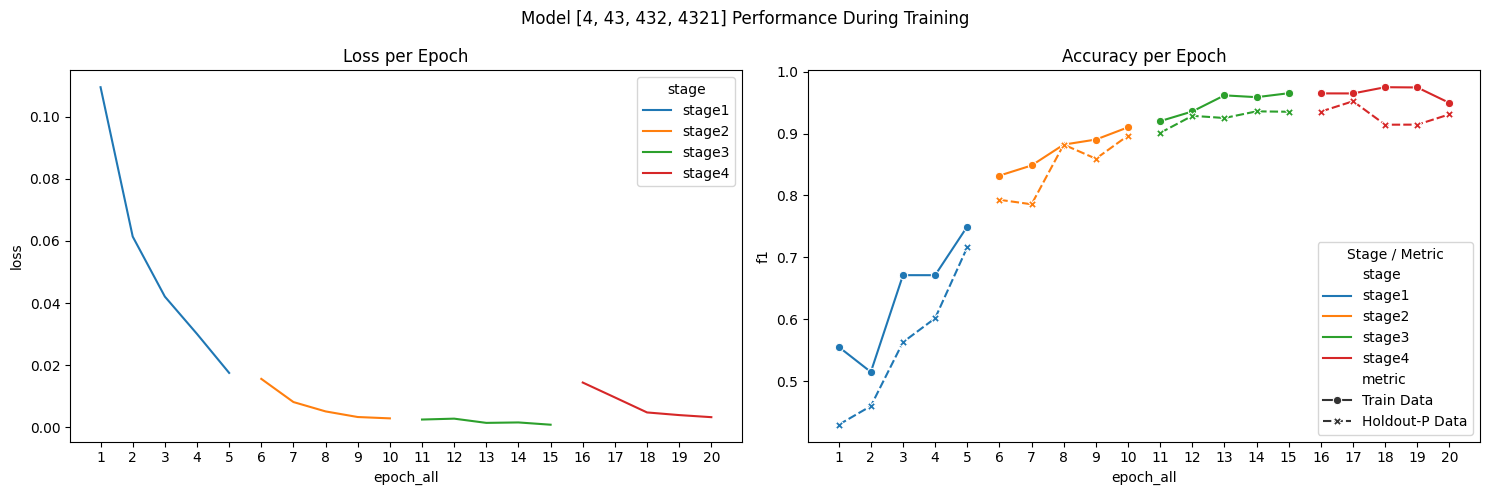

  y_true y_hat status d_type
0    sip   sip    all  train
1    air   air    all  train
2    yes   yes    all  train
3   sigh  sigh    all  train
4    sip   sip    all  train


<ipython-input-101-6bbd89793251>:109: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


<Figure size 1500x1500 with 0 Axes>

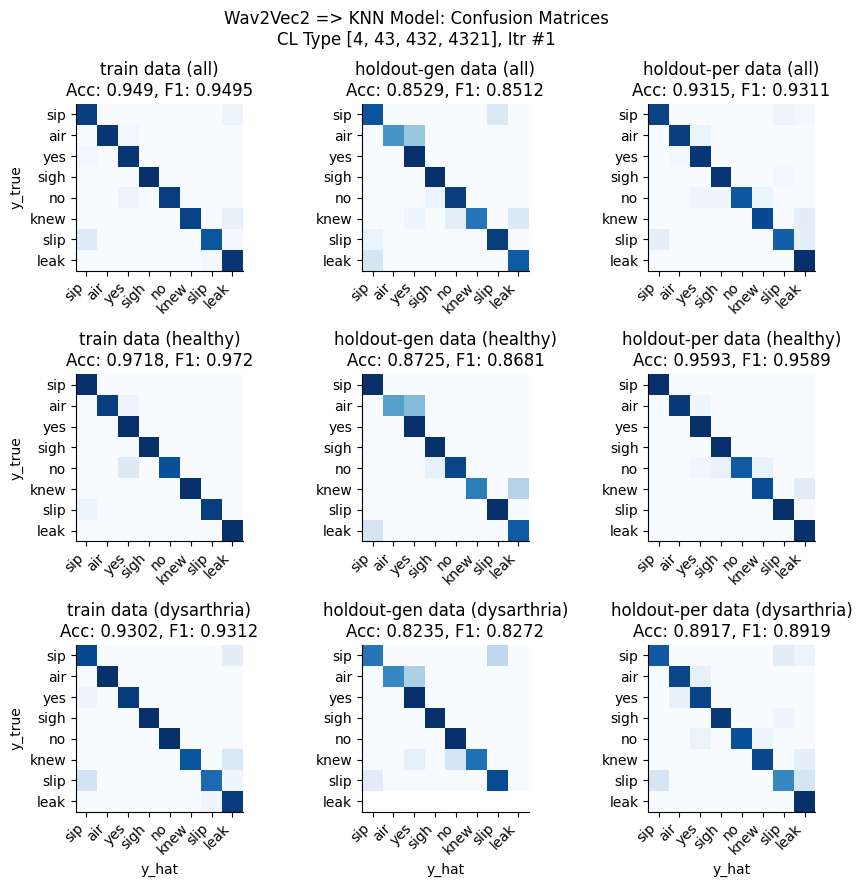

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Stage stage1: Using 352 triplets.
Stage stage2: Using 704 triplets.
Stage stage3: Using 880 triplets.
Stage stage4: Using 1232 triplets.
##################################
Training stage: stage1
##################################


100%|██████████| 44/44 [01:15<00:00,  1.71s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 75.14it/s]



Embedded 320ish audio files in 4.18 seconds.
Avg time per file: 0.0131 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 79.36it/s]



Embedded 296ish audio files in 3.68 seconds.
Avg time per file: 0.0124 seconds
Epoch 0 Loss:	0.1107


100%|██████████| 44/44 [01:15<00:00,  1.71s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.20it/s]



Embedded 320ish audio files in 4.24 seconds.
Avg time per file: 0.0132 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.99it/s]



Embedded 296ish audio files in 3.70 seconds.
Avg time per file: 0.0125 seconds
Epoch 1 Loss:	0.0624


100%|██████████| 44/44 [01:15<00:00,  1.71s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.21it/s]



Embedded 320ish audio files in 4.24 seconds.
Avg time per file: 0.0132 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.60it/s]



Embedded 296ish audio files in 3.72 seconds.
Avg time per file: 0.0126 seconds
Epoch 2 Loss:	0.0611


100%|██████████| 44/44 [01:15<00:00,  1.71s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.40it/s]



Embedded 320ish audio files in 4.22 seconds.
Avg time per file: 0.0132 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 79.41it/s]



Embedded 296ish audio files in 3.68 seconds.
Avg time per file: 0.0124 seconds
Epoch 3 Loss:	0.0592


100%|██████████| 44/44 [01:14<00:00,  1.70s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.68it/s]



Embedded 320ish audio files in 4.21 seconds.
Avg time per file: 0.0132 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.53it/s]



Embedded 296ish audio files in 3.72 seconds.
Avg time per file: 0.0126 seconds
Epoch 4 Loss:	0.0486
##################################
Training stage: stage2
##################################


100%|██████████| 88/88 [02:27<00:00,  1.68s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.60it/s]



Embedded 320ish audio files in 4.22 seconds.
Avg time per file: 0.0132 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.94it/s]



Embedded 296ish audio files in 3.70 seconds.
Avg time per file: 0.0125 seconds
Epoch 0 Loss:	0.0407


100%|██████████| 88/88 [02:25<00:00,  1.66s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.51it/s]



Embedded 320ish audio files in 4.22 seconds.
Avg time per file: 0.0132 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.82it/s]



Embedded 296ish audio files in 3.71 seconds.
Avg time per file: 0.0125 seconds
Epoch 1 Loss:	0.0278


100%|██████████| 88/88 [02:25<00:00,  1.65s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.49it/s]



Embedded 320ish audio files in 4.22 seconds.
Avg time per file: 0.0132 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.78it/s]



Embedded 296ish audio files in 3.71 seconds.
Avg time per file: 0.0125 seconds
Epoch 2 Loss:	0.0199


100%|██████████| 88/88 [02:24<00:00,  1.64s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.51it/s]



Embedded 320ish audio files in 4.22 seconds.
Avg time per file: 0.0132 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 79.28it/s]



Embedded 296ish audio files in 3.69 seconds.
Avg time per file: 0.0125 seconds
Epoch 3 Loss:	0.0153


100%|██████████| 88/88 [02:24<00:00,  1.64s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.46it/s]



Embedded 320ish audio files in 4.22 seconds.
Avg time per file: 0.0132 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.93it/s]



Embedded 296ish audio files in 3.71 seconds.
Avg time per file: 0.0125 seconds
Epoch 4 Loss:	0.0191
##################################
Training stage: stage3
##################################


100%|██████████| 110/110 [02:59<00:00,  1.63s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.46it/s]



Embedded 320ish audio files in 4.22 seconds.
Avg time per file: 0.0132 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.84it/s]



Embedded 296ish audio files in 3.71 seconds.
Avg time per file: 0.0125 seconds
Epoch 0 Loss:	0.0137


100%|██████████| 110/110 [02:59<00:00,  1.63s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.75it/s]



Embedded 320ish audio files in 4.20 seconds.
Avg time per file: 0.0131 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.69it/s]



Embedded 296ish audio files in 3.71 seconds.
Avg time per file: 0.0125 seconds
Epoch 1 Loss:	0.0140


100%|██████████| 110/110 [02:58<00:00,  1.62s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.80it/s]



Embedded 320ish audio files in 4.20 seconds.
Avg time per file: 0.0131 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 79.23it/s]



Embedded 296ish audio files in 3.69 seconds.
Avg time per file: 0.0125 seconds
Epoch 2 Loss:	0.0120


100%|██████████| 110/110 [02:58<00:00,  1.62s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.54it/s]



Embedded 320ish audio files in 4.22 seconds.
Avg time per file: 0.0132 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.77it/s]



Embedded 296ish audio files in 3.71 seconds.
Avg time per file: 0.0125 seconds
Epoch 3 Loss:	0.0101


100%|██████████| 110/110 [02:58<00:00,  1.62s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.34it/s]



Embedded 320ish audio files in 4.23 seconds.
Avg time per file: 0.0132 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.30it/s]



Embedded 296ish audio files in 3.74 seconds.
Avg time per file: 0.0126 seconds
Epoch 4 Loss:	0.0095
##################################
Training stage: stage4
##################################


100%|██████████| 154/154 [04:13<00:00,  1.65s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.79it/s]



Embedded 320ish audio files in 4.20 seconds.
Avg time per file: 0.0131 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 79.18it/s]



Embedded 296ish audio files in 3.69 seconds.
Avg time per file: 0.0125 seconds
Epoch 0 Loss:	0.0240


100%|██████████| 154/154 [04:15<00:00,  1.66s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.39it/s]



Embedded 320ish audio files in 4.23 seconds.
Avg time per file: 0.0132 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 79.03it/s]



Embedded 296ish audio files in 3.70 seconds.
Avg time per file: 0.0125 seconds
Epoch 1 Loss:	0.0288


100%|██████████| 154/154 [04:13<00:00,  1.64s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.80it/s]



Embedded 320ish audio files in 4.20 seconds.
Avg time per file: 0.0131 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 79.01it/s]



Embedded 296ish audio files in 3.70 seconds.
Avg time per file: 0.0125 seconds
Epoch 2 Loss:	0.0222


100%|██████████| 154/154 [04:12<00:00,  1.64s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.45it/s]



Embedded 320ish audio files in 4.22 seconds.
Avg time per file: 0.0132 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 79.13it/s]



Embedded 296ish audio files in 3.69 seconds.
Avg time per file: 0.0125 seconds
Epoch 3 Loss:	0.0195


100%|██████████| 154/154 [04:12<00:00,  1.64s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.34it/s]



Embedded 320ish audio files in 4.23 seconds.
Avg time per file: 0.0132 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 79.06it/s]



Embedded 296ish audio files in 3.70 seconds.
Avg time per file: 0.0125 seconds
Epoch 4 Loss:	0.0221
Training complete.
Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.39it/s]



Embedded 320ish audio files in 4.23 seconds.
Avg time per file: 0.0132 seconds
Embedding 170ish audio files.


100%|██████████| 170/170 [00:02<00:00, 72.40it/s]



Embedded 176ish audio files in 2.35 seconds.
Avg time per file: 0.0134 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.84it/s]
<ipython-input-100-e41e67df12a3>:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_to_plot = pd.concat([df_to_plot, pd.DataFrame({



Embedded 296ish audio files in 3.71 seconds.
Avg time per file: 0.0125 seconds
PARAMETER DICTIONARY:
margin: 0.5

lr: 1e-05

lrs: None

stages: {'stage1': {'triplet_types': ['4s', '4d'], 'speaker_status': ['healthy', 'dysarthria']}, 'stage2': {'triplet_types': ['4s', '4d', '3s', '3d'], 'speaker_status': ['healthy', 'dysarthria']}, 'stage3': {'triplet_types': ['4s', '4d', '3s', '3d', '2'], 'speaker_status': ['healthy', 'dysarthria']}, 'stage4': {'triplet_types': ['4s', '4d', '3s', '3d', '2', '1s', '1d'], 'speaker_status': ['healthy', 'dysarthria']}}

epochs: {'stage1': 5, 'stage2': 5, 'stage3': 5, 'stage4': 5}

| Dataset      | Subset     | Accuracy     | F1-Score  |
|--------------|------------|--------------|-----------|
| **Train**    | All        | 0.6943       | 0.6879        |
|              | Dysarthria | 0.6628       | 0.653   |
|              | Healthy    | 0.7324       | 0.7245     |
| **Hold-Gen** | All        | 0.6294       | 0.6055     |
|              | Dysarthria | 0.5  

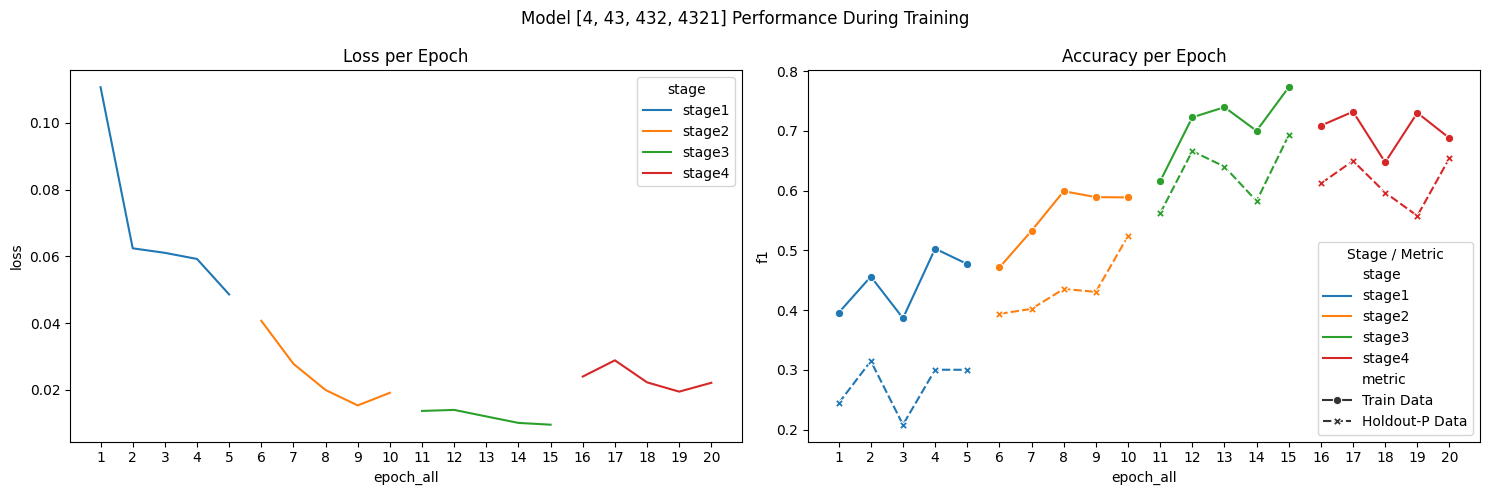

  y_true y_hat status d_type
0    sip   sip    all  train
1    air   air    all  train
2    yes   yes    all  train
3   sigh  sigh    all  train
4    sip  slip    all  train


<ipython-input-101-6bbd89793251>:109: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


<Figure size 1500x1500 with 0 Axes>

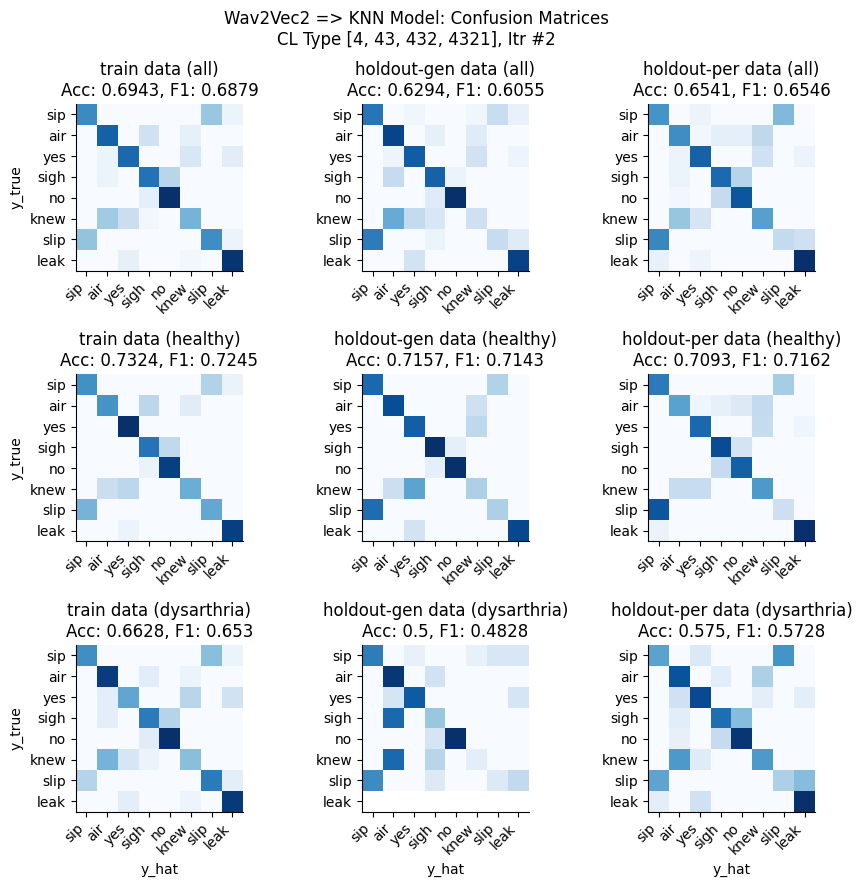

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Stage stage1: Using 352 triplets.
Stage stage2: Using 704 triplets.
Stage stage3: Using 880 triplets.
Stage stage4: Using 1232 triplets.
##################################
Training stage: stage1
##################################


100%|██████████| 44/44 [01:15<00:00,  1.71s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.82it/s]



Embedded 320ish audio files in 4.26 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.42it/s]



Embedded 296ish audio files in 3.73 seconds.
Avg time per file: 0.0126 seconds
Epoch 0 Loss:	0.1111


100%|██████████| 44/44 [01:15<00:00,  1.71s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.76it/s]



Embedded 320ish audio files in 4.26 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.25it/s]



Embedded 296ish audio files in 3.73 seconds.
Avg time per file: 0.0126 seconds
Epoch 1 Loss:	0.0550


100%|██████████| 44/44 [01:14<00:00,  1.68s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.88it/s]



Embedded 320ish audio files in 4.25 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.34it/s]



Embedded 296ish audio files in 3.73 seconds.
Avg time per file: 0.0126 seconds
Epoch 2 Loss:	0.0343


100%|██████████| 44/44 [01:13<00:00,  1.67s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.95it/s]



Embedded 320ish audio files in 4.25 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.37it/s]



Embedded 296ish audio files in 3.73 seconds.
Avg time per file: 0.0126 seconds
Epoch 3 Loss:	0.0140


100%|██████████| 44/44 [01:12<00:00,  1.66s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.74it/s]



Embedded 320ish audio files in 4.26 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.13it/s]



Embedded 296ish audio files in 3.74 seconds.
Avg time per file: 0.0126 seconds
Epoch 4 Loss:	0.0097
##################################
Training stage: stage2
##################################


100%|██████████| 88/88 [02:25<00:00,  1.65s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.20it/s]



Embedded 320ish audio files in 4.24 seconds.
Avg time per file: 0.0132 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.52it/s]



Embedded 296ish audio files in 3.72 seconds.
Avg time per file: 0.0126 seconds
Epoch 0 Loss:	0.0116


100%|██████████| 88/88 [02:24<00:00,  1.64s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.86it/s]



Embedded 320ish audio files in 4.26 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.06it/s]



Embedded 296ish audio files in 3.76 seconds.
Avg time per file: 0.0127 seconds
Epoch 1 Loss:	0.0064


100%|██████████| 88/88 [02:23<00:00,  1.63s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.30it/s]



Embedded 320ish audio files in 4.23 seconds.
Avg time per file: 0.0132 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.62it/s]



Embedded 296ish audio files in 3.72 seconds.
Avg time per file: 0.0126 seconds
Epoch 2 Loss:	0.0056


100%|██████████| 88/88 [02:22<00:00,  1.62s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.94it/s]



Embedded 320ish audio files in 4.25 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.27it/s]



Embedded 296ish audio files in 3.73 seconds.
Avg time per file: 0.0126 seconds
Epoch 3 Loss:	0.0032


100%|██████████| 88/88 [02:22<00:00,  1.62s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.01it/s]



Embedded 320ish audio files in 4.25 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.33it/s]



Embedded 296ish audio files in 3.73 seconds.
Avg time per file: 0.0126 seconds
Epoch 4 Loss:	0.0025
##################################
Training stage: stage3
##################################


100%|██████████| 110/110 [02:57<00:00,  1.61s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.12it/s]



Embedded 320ish audio files in 4.24 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.64it/s]



Embedded 296ish audio files in 3.72 seconds.
Avg time per file: 0.0126 seconds
Epoch 0 Loss:	0.0042


100%|██████████| 110/110 [02:57<00:00,  1.61s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.77it/s]



Embedded 320ish audio files in 4.26 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 77.96it/s]



Embedded 296ish audio files in 3.75 seconds.
Avg time per file: 0.0127 seconds
Epoch 1 Loss:	0.0030


100%|██████████| 110/110 [02:56<00:00,  1.60s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.04it/s]



Embedded 320ish audio files in 4.25 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.55it/s]



Embedded 296ish audio files in 3.72 seconds.
Avg time per file: 0.0126 seconds
Epoch 2 Loss:	0.0017


100%|██████████| 110/110 [02:55<00:00,  1.60s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.13it/s]



Embedded 320ish audio files in 4.24 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.82it/s]



Embedded 296ish audio files in 3.71 seconds.
Avg time per file: 0.0125 seconds
Epoch 3 Loss:	0.0009


100%|██████████| 110/110 [02:55<00:00,  1.59s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.83it/s]



Embedded 320ish audio files in 4.26 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 77.92it/s]



Embedded 296ish audio files in 3.75 seconds.
Avg time per file: 0.0127 seconds
Epoch 4 Loss:	0.0007
##################################
Training stage: stage4
##################################


100%|██████████| 154/154 [04:13<00:00,  1.64s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.80it/s]



Embedded 320ish audio files in 4.26 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.36it/s]



Embedded 296ish audio files in 3.73 seconds.
Avg time per file: 0.0126 seconds
Epoch 0 Loss:	0.0151


100%|██████████| 154/154 [04:12<00:00,  1.64s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.15it/s]



Embedded 320ish audio files in 4.24 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.45it/s]



Embedded 296ish audio files in 3.73 seconds.
Avg time per file: 0.0126 seconds
Epoch 1 Loss:	0.0095


100%|██████████| 154/154 [04:09<00:00,  1.62s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.28it/s]



Embedded 320ish audio files in 4.24 seconds.
Avg time per file: 0.0132 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.62it/s]



Embedded 296ish audio files in 3.72 seconds.
Avg time per file: 0.0126 seconds
Epoch 2 Loss:	0.0065


100%|██████████| 154/154 [04:10<00:00,  1.62s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.26it/s]



Embedded 320ish audio files in 4.23 seconds.
Avg time per file: 0.0132 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.63it/s]



Embedded 296ish audio files in 3.72 seconds.
Avg time per file: 0.0126 seconds
Epoch 3 Loss:	0.0057


100%|██████████| 154/154 [04:09<00:00,  1.62s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.12it/s]



Embedded 320ish audio files in 4.24 seconds.
Avg time per file: 0.0132 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 77.98it/s]



Embedded 296ish audio files in 3.75 seconds.
Avg time per file: 0.0127 seconds
Epoch 4 Loss:	0.0041
Training complete.
Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.67it/s]



Embedded 320ish audio files in 4.27 seconds.
Avg time per file: 0.0133 seconds
Embedding 170ish audio files.


100%|██████████| 170/170 [00:02<00:00, 72.36it/s]



Embedded 176ish audio files in 2.35 seconds.
Avg time per file: 0.0134 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.06it/s]
<ipython-input-100-e41e67df12a3>:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_to_plot = pd.concat([df_to_plot, pd.DataFrame({



Embedded 296ish audio files in 3.74 seconds.
Avg time per file: 0.0127 seconds
PARAMETER DICTIONARY:
margin: 0.5

lr: 1e-05

lrs: None

stages: {'stage1': {'triplet_types': ['4s', '4d'], 'speaker_status': ['healthy', 'dysarthria']}, 'stage2': {'triplet_types': ['4s', '4d', '3s', '3d'], 'speaker_status': ['healthy', 'dysarthria']}, 'stage3': {'triplet_types': ['4s', '4d', '3s', '3d', '2'], 'speaker_status': ['healthy', 'dysarthria']}, 'stage4': {'triplet_types': ['4s', '4d', '3s', '3d', '2', '1s', '1d'], 'speaker_status': ['healthy', 'dysarthria']}}

epochs: {'stage1': 5, 'stage2': 5, 'stage3': 5, 'stage4': 5}

| Dataset      | Subset     | Accuracy     | F1-Score  |
|--------------|------------|--------------|-----------|
| **Train**    | All        | 0.9554       | 0.9555        |
|              | Dysarthria | 0.9419       | 0.9425   |
|              | Healthy    | 0.9718       | 0.9716     |
| **Hold-Gen** | All        | 0.9235       | 0.9229     |
|              | Dysarthria | 0.88

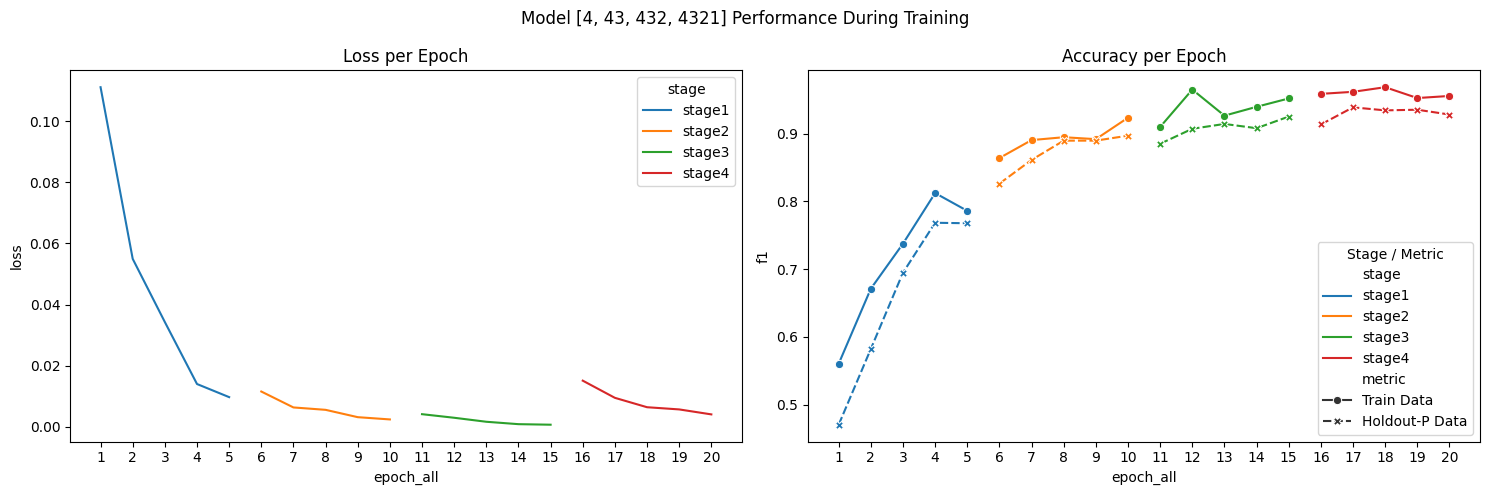

  y_true y_hat status d_type
0    sip   sip    all  train
1    air   air    all  train
2    yes   yes    all  train
3   sigh  sigh    all  train
4    sip   sip    all  train


<ipython-input-101-6bbd89793251>:109: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


<Figure size 1500x1500 with 0 Axes>

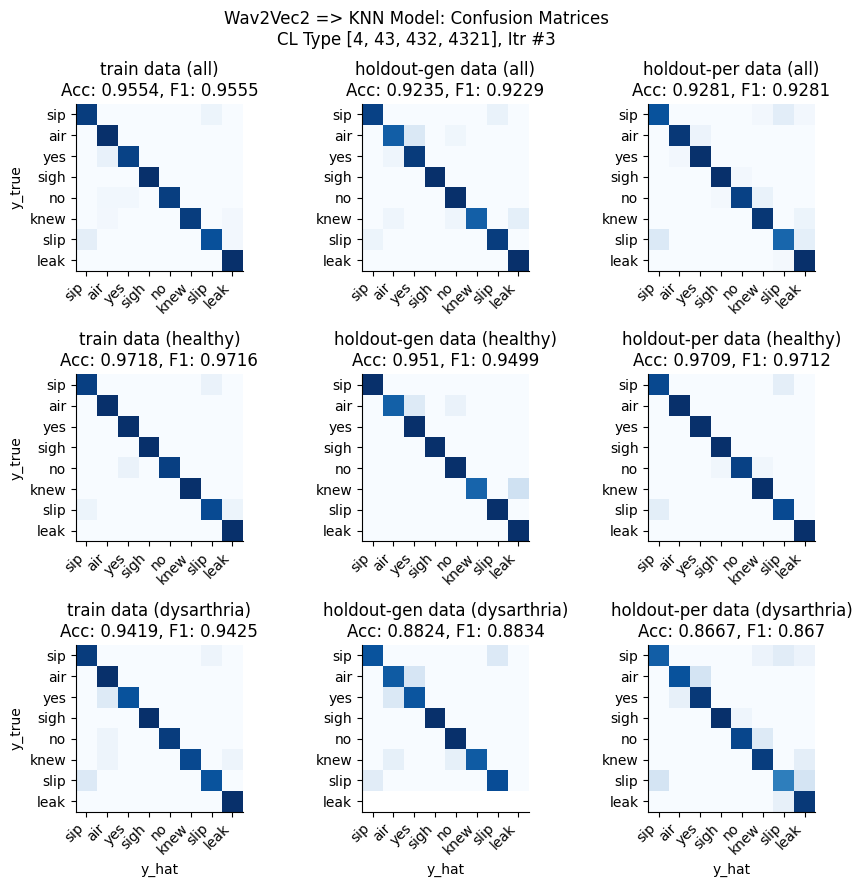

In [ ]:
model_str = "3"
stages_map = models_metamap[model_str]['stagemap']
print(stages_map)
epochs_map = models_metamap[model_str]['epoch_map']
print(epochs_map)
seed_list = [100,200,300]

for ii, seed_value in enumerate(seed_list):
    itr_str = str(ii+1)
    # set seed.
    torch.manual_seed(seed_value)
    np.random.seed(seed_value)
    random.seed(seed_value)

    df_embed_train, df_embed_h_gen, df_embed_h_per, history_dict = pcccl_handler(
        df_triplets, df_torgo,
        stages_map, epochs_map,
        v_margin=.5, v_lr=1e-5)

    plot_model_history(history_dict, model_str, itr_str)
    eval_embeddings_cm(df_embed_train, df_embed_h_gen, df_embed_h_per, model_type=model_str, itr_type=itr_str)


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Stage stage1: Using 320 triplets.
Stage stage2: Using 384 triplets.
Stage stage3: Using 1232 triplets.
##################################
Training stage: stage1
##################################


100%|██████████| 40/40 [01:08<00:00,  1.72s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.74it/s]



Embedded 320ish audio files in 4.21 seconds.
Avg time per file: 0.0132 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 79.52it/s]



Embedded 296ish audio files in 3.68 seconds.
Avg time per file: 0.0124 seconds
Epoch 0 Loss:	0.1239


100%|██████████| 40/40 [01:08<00:00,  1.70s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.91it/s]



Embedded 320ish audio files in 4.25 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.28it/s]



Embedded 296ish audio files in 3.73 seconds.
Avg time per file: 0.0126 seconds
Epoch 1 Loss:	0.0598


100%|██████████| 40/40 [01:07<00:00,  1.69s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.71it/s]



Embedded 320ish audio files in 4.26 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.06it/s]



Embedded 296ish audio files in 3.74 seconds.
Avg time per file: 0.0126 seconds
Epoch 2 Loss:	0.0397


100%|██████████| 40/40 [01:07<00:00,  1.68s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.85it/s]



Embedded 320ish audio files in 4.25 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.29it/s]



Embedded 296ish audio files in 3.73 seconds.
Avg time per file: 0.0126 seconds
Epoch 3 Loss:	0.0251


100%|██████████| 40/40 [01:06<00:00,  1.67s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.37it/s]



Embedded 320ish audio files in 4.23 seconds.
Avg time per file: 0.0132 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.45it/s]



Embedded 296ish audio files in 3.73 seconds.
Avg time per file: 0.0126 seconds
Epoch 4 Loss:	0.0256
##################################
Training stage: stage2
##################################


100%|██████████| 48/48 [01:21<00:00,  1.69s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.83it/s]



Embedded 320ish audio files in 4.26 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.34it/s]



Embedded 296ish audio files in 3.73 seconds.
Avg time per file: 0.0126 seconds
Epoch 0 Loss:	0.0445


100%|██████████| 48/48 [01:19<00:00,  1.67s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.17it/s]



Embedded 320ish audio files in 4.24 seconds.
Avg time per file: 0.0132 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.71it/s]



Embedded 296ish audio files in 3.71 seconds.
Avg time per file: 0.0125 seconds
Epoch 1 Loss:	0.0260


100%|██████████| 48/48 [01:19<00:00,  1.66s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.80it/s]



Embedded 320ish audio files in 4.26 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.17it/s]



Embedded 296ish audio files in 3.74 seconds.
Avg time per file: 0.0126 seconds
Epoch 2 Loss:	0.0240


100%|██████████| 48/48 [01:19<00:00,  1.65s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.83it/s]



Embedded 320ish audio files in 4.26 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.40it/s]



Embedded 296ish audio files in 3.73 seconds.
Avg time per file: 0.0126 seconds
Epoch 3 Loss:	0.0161


100%|██████████| 48/48 [01:19<00:00,  1.65s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.05it/s]



Embedded 320ish audio files in 4.24 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.17it/s]



Embedded 296ish audio files in 3.74 seconds.
Avg time per file: 0.0126 seconds
Epoch 4 Loss:	0.0114
##################################
Training stage: stage3
##################################


100%|██████████| 154/154 [04:14<00:00,  1.65s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.02it/s]



Embedded 320ish audio files in 4.25 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.18it/s]



Embedded 296ish audio files in 3.74 seconds.
Avg time per file: 0.0126 seconds
Epoch 0 Loss:	0.0197


100%|██████████| 154/154 [04:12<00:00,  1.64s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.93it/s]



Embedded 320ish audio files in 4.25 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.66it/s]



Embedded 296ish audio files in 3.72 seconds.
Avg time per file: 0.0126 seconds
Epoch 1 Loss:	0.0115


100%|██████████| 154/154 [04:11<00:00,  1.63s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.04it/s]



Embedded 320ish audio files in 4.25 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.50it/s]



Embedded 296ish audio files in 3.72 seconds.
Avg time per file: 0.0126 seconds
Epoch 2 Loss:	0.0067


100%|██████████| 154/154 [04:10<00:00,  1.63s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.08it/s]



Embedded 320ish audio files in 4.25 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.16it/s]



Embedded 296ish audio files in 3.74 seconds.
Avg time per file: 0.0126 seconds
Epoch 3 Loss:	0.0066


100%|██████████| 154/154 [04:10<00:00,  1.63s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.17it/s]



Embedded 320ish audio files in 4.24 seconds.
Avg time per file: 0.0132 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.61it/s]



Embedded 296ish audio files in 3.72 seconds.
Avg time per file: 0.0126 seconds
Epoch 4 Loss:	0.0064
Training complete.
Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.27it/s]



Embedded 320ish audio files in 4.24 seconds.
Avg time per file: 0.0132 seconds
Embedding 170ish audio files.


100%|██████████| 170/170 [00:02<00:00, 72.23it/s]



Embedded 176ish audio files in 2.36 seconds.
Avg time per file: 0.0134 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.35it/s]
<ipython-input-100-e41e67df12a3>:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_to_plot = pd.concat([df_to_plot, pd.DataFrame({



Embedded 296ish audio files in 3.73 seconds.
Avg time per file: 0.0126 seconds
PARAMETER DICTIONARY:
margin: 0.5

lr: 1e-05

lrs: None

stages: {'stage1': {'triplet_types': ['1s', '1d', '2', '3s', '3d', '4s', '4d'], 'speaker_status': ['healthy']}, 'stage2': {'triplet_types': ['1s', '1d', '2', '3s', '3d', '4s', '4d'], 'speaker_status': ['dysarthria']}, 'stage3': {'triplet_types': ['1s', '1d', '2', '3s', '3d', '4s', '4d'], 'speaker_status': ['healthy', 'dysarthria']}}

epochs: {'stage1': 5, 'stage2': 5, 'stage3': 5}

| Dataset      | Subset     | Accuracy     | F1-Score  |
|--------------|------------|--------------|-----------|
| **Train**    | All        | 0.8949       | 0.8936        |
|              | Dysarthria | 0.8663       | 0.8604   |
|              | Healthy    | 0.9296       | 0.9282     |
| **Hold-Gen** | All        | 0.8353       | 0.8318     |
|              | Dysarthria | 0.7206       | 0.7336     |
|              | Healthy    | 0.9118       | 0.9059     |
| **Hold-Per** 

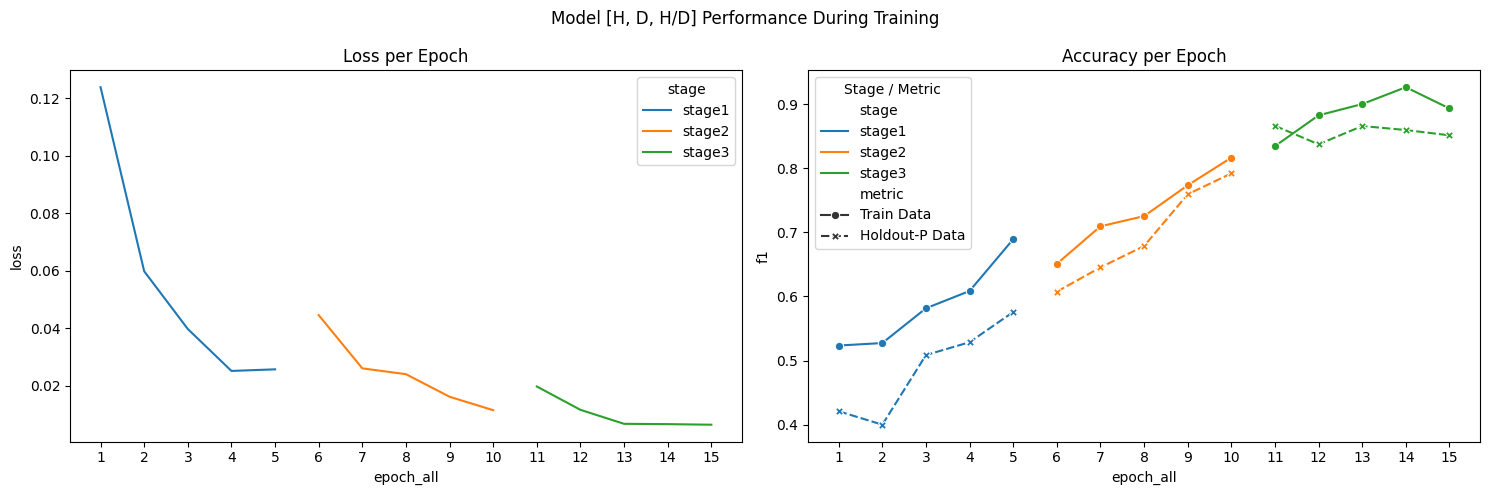

  y_true y_hat status d_type
0    sip  leak    all  train
1    air   air    all  train
2    yes   yes    all  train
3   sigh  sigh    all  train
4    sip  leak    all  train


<ipython-input-101-6bbd89793251>:109: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


<Figure size 1500x1500 with 0 Axes>

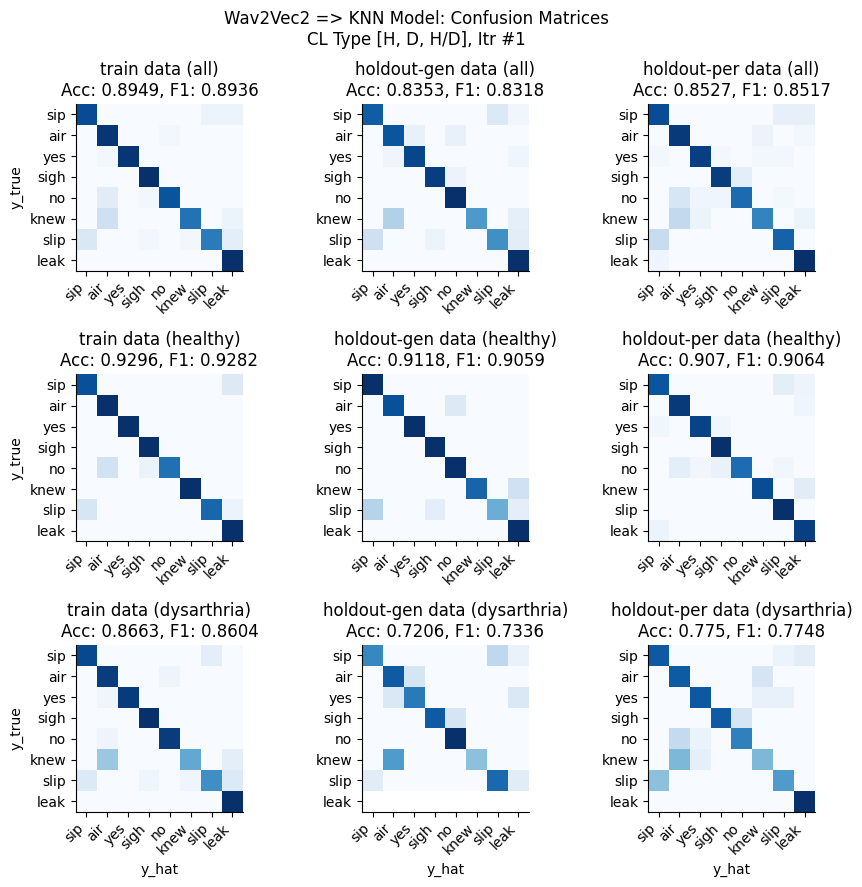

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Stage stage1: Using 320 triplets.
Stage stage2: Using 384 triplets.
Stage stage3: Using 1232 triplets.
##################################
Training stage: stage1
##################################


100%|██████████| 40/40 [01:08<00:00,  1.71s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.43it/s]



Embedded 320ish audio files in 4.22 seconds.
Avg time per file: 0.0132 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.74it/s]



Embedded 296ish audio files in 3.71 seconds.
Avg time per file: 0.0125 seconds
Epoch 0 Loss:	0.1133


100%|██████████| 40/40 [01:08<00:00,  1.71s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.55it/s]



Embedded 320ish audio files in 4.27 seconds.
Avg time per file: 0.0134 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.38it/s]



Embedded 296ish audio files in 3.73 seconds.
Avg time per file: 0.0126 seconds
Epoch 1 Loss:	0.0590


100%|██████████| 40/40 [01:08<00:00,  1.70s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.10it/s]



Embedded 320ish audio files in 4.24 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.66it/s]



Embedded 296ish audio files in 3.71 seconds.
Avg time per file: 0.0125 seconds
Epoch 2 Loss:	0.0479


100%|██████████| 40/40 [01:07<00:00,  1.69s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.02it/s]



Embedded 320ish audio files in 4.25 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.23it/s]



Embedded 296ish audio files in 3.74 seconds.
Avg time per file: 0.0126 seconds
Epoch 3 Loss:	0.0339


100%|██████████| 40/40 [01:06<00:00,  1.67s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.77it/s]



Embedded 320ish audio files in 4.26 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.08it/s]



Embedded 296ish audio files in 3.74 seconds.
Avg time per file: 0.0126 seconds
Epoch 4 Loss:	0.0252
##################################
Training stage: stage2
##################################


100%|██████████| 48/48 [01:21<00:00,  1.70s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.94it/s]



Embedded 320ish audio files in 4.25 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.10it/s]



Embedded 296ish audio files in 3.74 seconds.
Avg time per file: 0.0126 seconds
Epoch 0 Loss:	0.0479


100%|██████████| 48/48 [01:20<00:00,  1.67s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.09it/s]



Embedded 320ish audio files in 4.25 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.51it/s]



Embedded 296ish audio files in 3.72 seconds.
Avg time per file: 0.0126 seconds
Epoch 1 Loss:	0.0253


100%|██████████| 48/48 [01:19<00:00,  1.65s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.00it/s]



Embedded 320ish audio files in 4.25 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.06it/s]



Embedded 296ish audio files in 3.75 seconds.
Avg time per file: 0.0127 seconds
Epoch 2 Loss:	0.0174


100%|██████████| 48/48 [01:19<00:00,  1.66s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.63it/s]



Embedded 320ish audio files in 4.27 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.23it/s]



Embedded 296ish audio files in 3.74 seconds.
Avg time per file: 0.0126 seconds
Epoch 3 Loss:	0.0147


100%|██████████| 48/48 [01:19<00:00,  1.66s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.61it/s]



Embedded 320ish audio files in 4.27 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.25it/s]



Embedded 296ish audio files in 3.73 seconds.
Avg time per file: 0.0126 seconds
Epoch 4 Loss:	0.0115
##################################
Training stage: stage3
##################################


100%|██████████| 154/154 [04:13<00:00,  1.65s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.12it/s]



Embedded 320ish audio files in 4.24 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.47it/s]



Embedded 296ish audio files in 3.72 seconds.
Avg time per file: 0.0126 seconds
Epoch 0 Loss:	0.0133


100%|██████████| 154/154 [04:12<00:00,  1.64s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.00it/s]



Embedded 320ish audio files in 4.25 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 77.97it/s]



Embedded 296ish audio files in 3.75 seconds.
Avg time per file: 0.0127 seconds
Epoch 1 Loss:	0.0101


100%|██████████| 154/154 [04:11<00:00,  1.63s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.03it/s]



Embedded 320ish audio files in 4.24 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.24it/s]



Embedded 296ish audio files in 3.73 seconds.
Avg time per file: 0.0126 seconds
Epoch 2 Loss:	0.0059


100%|██████████| 154/154 [04:10<00:00,  1.63s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.76it/s]



Embedded 320ish audio files in 4.26 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.32it/s]



Embedded 296ish audio files in 3.73 seconds.
Avg time per file: 0.0126 seconds
Epoch 3 Loss:	0.0051


100%|██████████| 154/154 [04:10<00:00,  1.62s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.97it/s]



Embedded 320ish audio files in 4.25 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.29it/s]



Embedded 296ish audio files in 3.74 seconds.
Avg time per file: 0.0126 seconds
Epoch 4 Loss:	0.0049
Training complete.
Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.89it/s]



Embedded 320ish audio files in 4.26 seconds.
Avg time per file: 0.0133 seconds
Embedding 170ish audio files.


100%|██████████| 170/170 [00:02<00:00, 72.54it/s]



Embedded 176ish audio files in 2.35 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 77.90it/s]
<ipython-input-100-e41e67df12a3>:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_to_plot = pd.concat([df_to_plot, pd.DataFrame({



Embedded 296ish audio files in 3.75 seconds.
Avg time per file: 0.0127 seconds
PARAMETER DICTIONARY:
margin: 0.5

lr: 1e-05

lrs: None

stages: {'stage1': {'triplet_types': ['1s', '1d', '2', '3s', '3d', '4s', '4d'], 'speaker_status': ['healthy']}, 'stage2': {'triplet_types': ['1s', '1d', '2', '3s', '3d', '4s', '4d'], 'speaker_status': ['dysarthria']}, 'stage3': {'triplet_types': ['1s', '1d', '2', '3s', '3d', '4s', '4d'], 'speaker_status': ['healthy', 'dysarthria']}}

epochs: {'stage1': 5, 'stage2': 5, 'stage3': 5}

| Dataset      | Subset     | Accuracy     | F1-Score  |
|--------------|------------|--------------|-----------|
| **Train**    | All        | 0.9618       | 0.9618        |
|              | Dysarthria | 0.9767       | 0.9767   |
|              | Healthy    | 0.9437       | 0.9432     |
| **Hold-Gen** | All        | 0.8471       | 0.8469     |
|              | Dysarthria | 0.75       | 0.7175     |
|              | Healthy    | 0.9118       | 0.9079     |
| **Hold-Per** | 

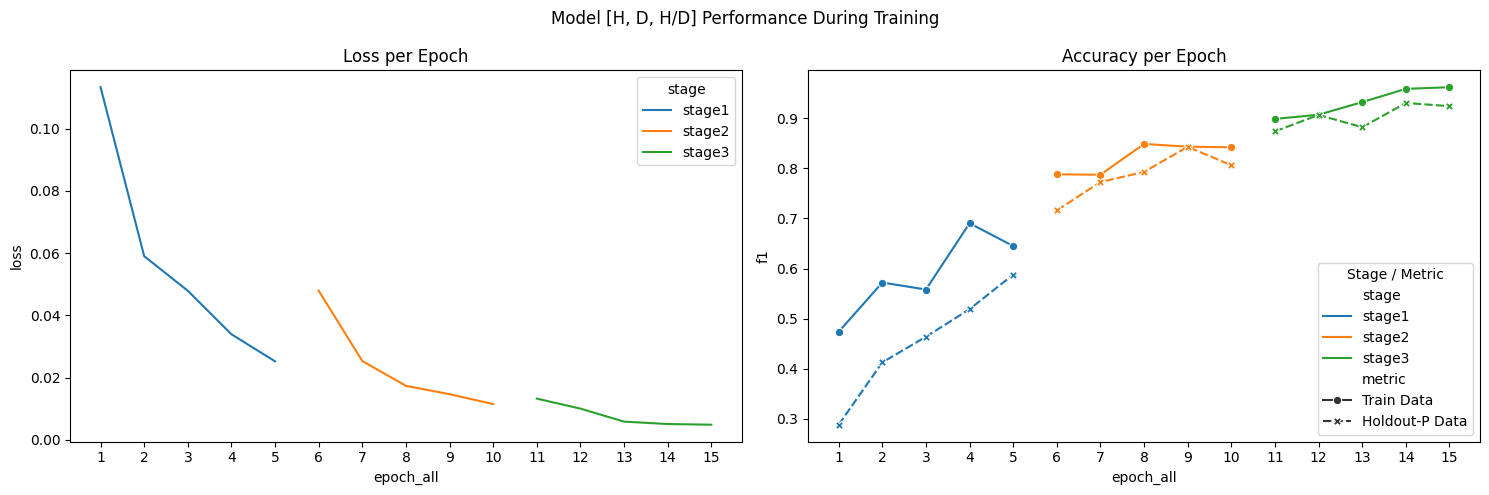

  y_true y_hat status d_type
0    sip   sip    all  train
1    air   air    all  train
2    yes   yes    all  train
3   sigh  sigh    all  train
4    sip   sip    all  train


<ipython-input-101-6bbd89793251>:109: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


<Figure size 1500x1500 with 0 Axes>

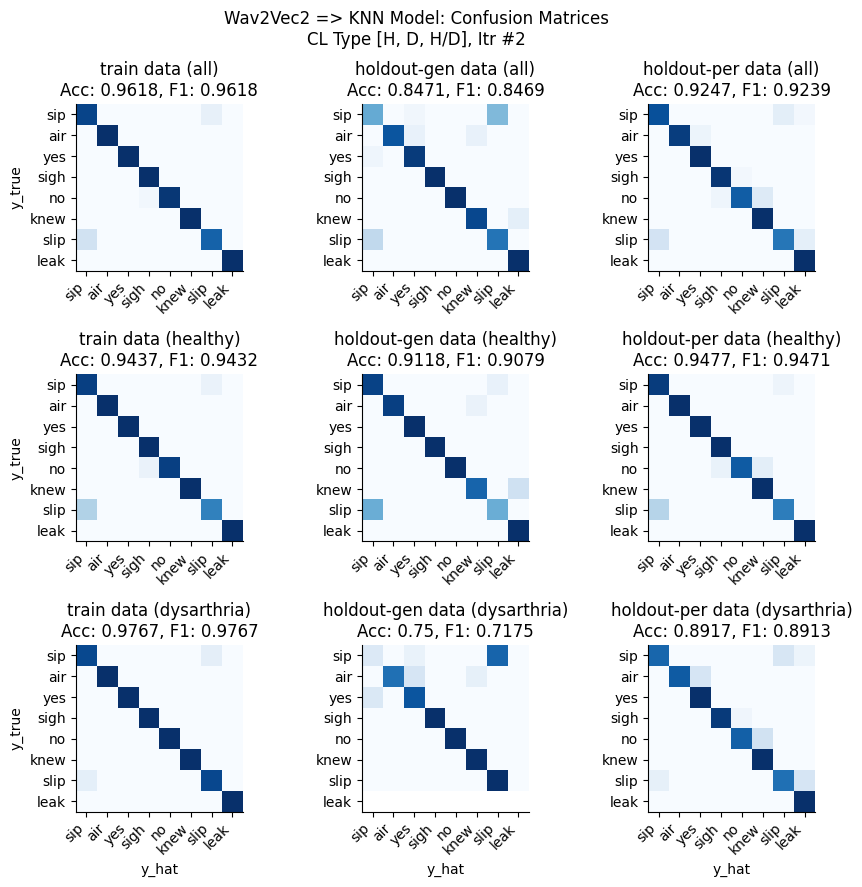

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Stage stage1: Using 320 triplets.
Stage stage2: Using 384 triplets.
Stage stage3: Using 1232 triplets.
##################################
Training stage: stage1
##################################


100%|██████████| 40/40 [01:08<00:00,  1.71s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.52it/s]



Embedded 320ish audio files in 4.22 seconds.
Avg time per file: 0.0132 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.91it/s]



Embedded 296ish audio files in 3.71 seconds.
Avg time per file: 0.0125 seconds
Epoch 0 Loss:	0.1144


100%|██████████| 40/40 [01:08<00:00,  1.71s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.81it/s]



Embedded 320ish audio files in 4.26 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.37it/s]



Embedded 296ish audio files in 3.73 seconds.
Avg time per file: 0.0126 seconds
Epoch 1 Loss:	0.0516


100%|██████████| 40/40 [01:08<00:00,  1.70s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.86it/s]



Embedded 320ish audio files in 4.26 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.10it/s]



Embedded 296ish audio files in 3.74 seconds.
Avg time per file: 0.0126 seconds
Epoch 2 Loss:	0.0445


100%|██████████| 40/40 [01:07<00:00,  1.69s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.64it/s]



Embedded 320ish audio files in 4.27 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.38it/s]



Embedded 296ish audio files in 3.73 seconds.
Avg time per file: 0.0126 seconds
Epoch 3 Loss:	0.0295


100%|██████████| 40/40 [01:06<00:00,  1.67s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.02it/s]



Embedded 320ish audio files in 4.25 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 77.94it/s]



Embedded 296ish audio files in 3.75 seconds.
Avg time per file: 0.0127 seconds
Epoch 4 Loss:	0.0229
##################################
Training stage: stage2
##################################


100%|██████████| 48/48 [01:21<00:00,  1.70s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.95it/s]



Embedded 320ish audio files in 4.25 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.20it/s]



Embedded 296ish audio files in 3.74 seconds.
Avg time per file: 0.0126 seconds
Epoch 0 Loss:	0.0466


100%|██████████| 48/48 [01:20<00:00,  1.68s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.48it/s]



Embedded 320ish audio files in 4.28 seconds.
Avg time per file: 0.0134 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.19it/s]



Embedded 296ish audio files in 3.74 seconds.
Avg time per file: 0.0126 seconds
Epoch 1 Loss:	0.0273


100%|██████████| 48/48 [01:19<00:00,  1.66s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.70it/s]



Embedded 320ish audio files in 4.26 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.38it/s]



Embedded 296ish audio files in 3.73 seconds.
Avg time per file: 0.0126 seconds
Epoch 2 Loss:	0.0160


100%|██████████| 48/48 [01:19<00:00,  1.65s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.24it/s]



Embedded 320ish audio files in 4.23 seconds.
Avg time per file: 0.0132 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.74it/s]



Embedded 296ish audio files in 3.71 seconds.
Avg time per file: 0.0125 seconds
Epoch 3 Loss:	0.0167


100%|██████████| 48/48 [01:19<00:00,  1.65s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.00it/s]



Embedded 320ish audio files in 4.25 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.61it/s]



Embedded 296ish audio files in 3.72 seconds.
Avg time per file: 0.0126 seconds
Epoch 4 Loss:	0.0121
##################################
Training stage: stage3
##################################


100%|██████████| 154/154 [04:13<00:00,  1.65s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.78it/s]



Embedded 320ish audio files in 4.26 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 77.96it/s]



Embedded 296ish audio files in 3.75 seconds.
Avg time per file: 0.0127 seconds
Epoch 0 Loss:	0.0143


100%|██████████| 154/154 [04:12<00:00,  1.64s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.95it/s]



Embedded 320ish audio files in 4.25 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.45it/s]



Embedded 296ish audio files in 3.73 seconds.
Avg time per file: 0.0126 seconds
Epoch 1 Loss:	0.0098


100%|██████████| 154/154 [04:10<00:00,  1.62s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 74.10it/s]



Embedded 320ish audio files in 4.25 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.82it/s]



Embedded 296ish audio files in 3.71 seconds.
Avg time per file: 0.0125 seconds
Epoch 2 Loss:	0.0069


100%|██████████| 154/154 [04:10<00:00,  1.63s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.95it/s]



Embedded 320ish audio files in 4.25 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.46it/s]



Embedded 296ish audio files in 3.73 seconds.
Avg time per file: 0.0126 seconds
Epoch 3 Loss:	0.0063


100%|██████████| 154/154 [04:08<00:00,  1.62s/it]


Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.75it/s]



Embedded 320ish audio files in 4.26 seconds.
Avg time per file: 0.0133 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.42it/s]



Embedded 296ish audio files in 3.73 seconds.
Avg time per file: 0.0126 seconds
Epoch 4 Loss:	0.0031
Training complete.
Embedding 314ish audio files.


100%|██████████| 314/314 [00:04<00:00, 73.94it/s]



Embedded 320ish audio files in 4.26 seconds.
Avg time per file: 0.0133 seconds
Embedding 170ish audio files.


100%|██████████| 170/170 [00:02<00:00, 72.41it/s]



Embedded 176ish audio files in 2.35 seconds.
Avg time per file: 0.0134 seconds
Embedding 292ish audio files.


100%|██████████| 292/292 [00:03<00:00, 78.42it/s]
<ipython-input-100-e41e67df12a3>:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_to_plot = pd.concat([df_to_plot, pd.DataFrame({



Embedded 296ish audio files in 3.73 seconds.
Avg time per file: 0.0126 seconds
PARAMETER DICTIONARY:
margin: 0.5

lr: 1e-05

lrs: None

stages: {'stage1': {'triplet_types': ['1s', '1d', '2', '3s', '3d', '4s', '4d'], 'speaker_status': ['healthy']}, 'stage2': {'triplet_types': ['1s', '1d', '2', '3s', '3d', '4s', '4d'], 'speaker_status': ['dysarthria']}, 'stage3': {'triplet_types': ['1s', '1d', '2', '3s', '3d', '4s', '4d'], 'speaker_status': ['healthy', 'dysarthria']}}

epochs: {'stage1': 5, 'stage2': 5, 'stage3': 5}

| Dataset      | Subset     | Accuracy     | F1-Score  |
|--------------|------------|--------------|-----------|
| **Train**    | All        | 0.9299       | 0.9288        |
|              | Dysarthria | 0.8953       | 0.8915   |
|              | Healthy    | 0.9718       | 0.9713     |
| **Hold-Gen** | All        | 0.8235       | 0.8248     |
|              | Dysarthria | 0.7206       | 0.7416     |
|              | Healthy    | 0.8922       | 0.8873     |
| **Hold-Per** 

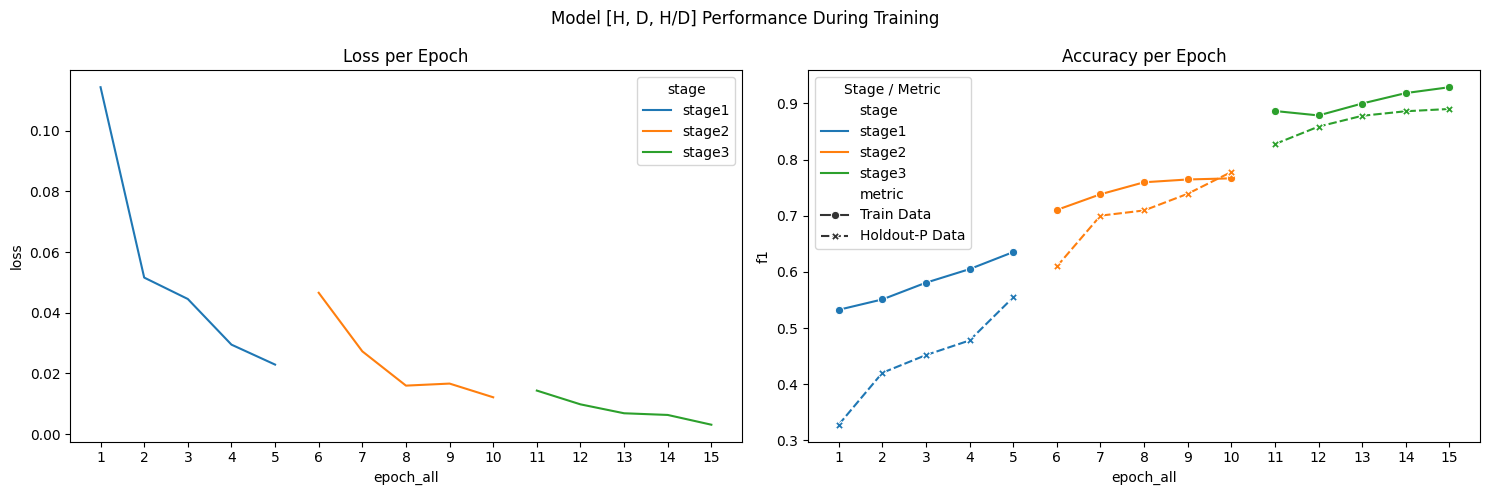

  y_true y_hat status d_type
0    sip   sip    all  train
1    air   air    all  train
2    yes   yes    all  train
3   sigh  sigh    all  train
4    sip   sip    all  train


<ipython-input-101-6bbd89793251>:109: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


<Figure size 1500x1500 with 0 Axes>

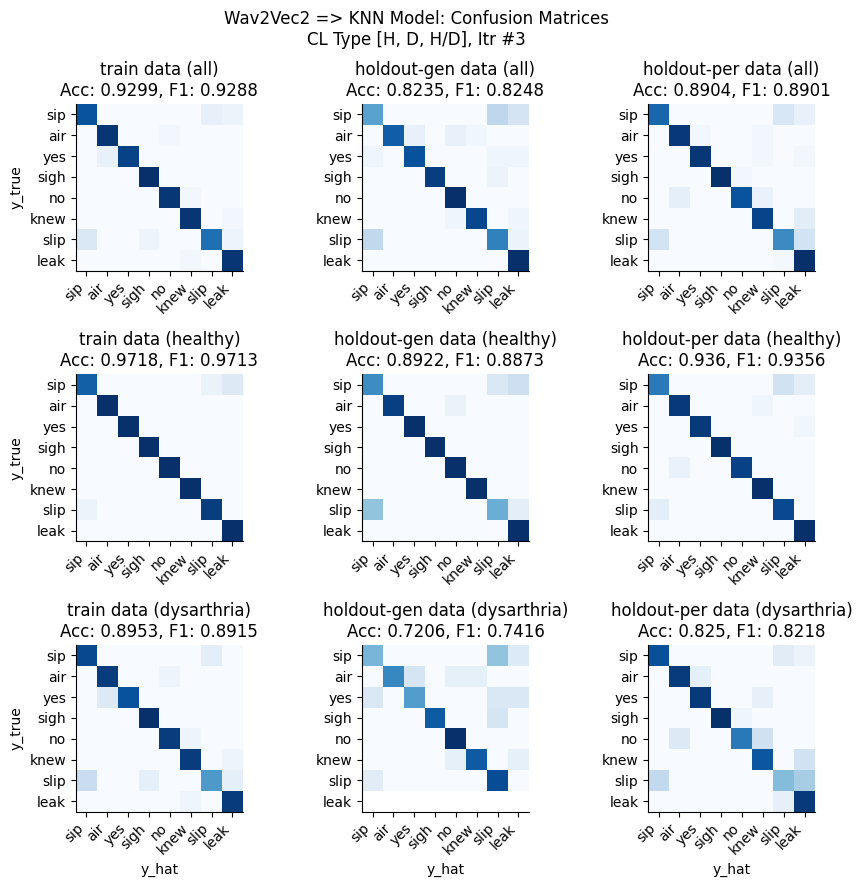

In [ ]:
# Triplet Map
stages_map = {
  'stage1': {
    'triplet_types': ['1s', '1d', '2', '3s', '3d', '4s', '4d'],
    'speaker_status': ['healthy']},
  'stage2': {
    'triplet_types': ['1s', '1d', '2', '3s', '3d', '4s', '4d'],
    'speaker_status': ['dysarthria']},
  'stage3': {
    'triplet_types': ['1s', '1d', '2', '3s', '3d', '4s', '4d'],
    'speaker_status': ['healthy', 'dysarthria']}
}

epochs_map = {
    "stage1": 5, "stage2": 5, "stage3": 5,
}

seed_list = [100,200,300]

for ii, seed_value in enumerate(seed_list):
  itr_str = str(ii+1)
  # set seed.
  torch.manual_seed(seed_value)
  np.random.seed(seed_value)
  random.seed(seed_value)

  df_embed_train, df_embed_h_gen, df_embed_h_per, history_dict = pcccl_handler(
      df_triplets, df_torgo,
      stages_map, epochs_map,
      v_margin=.5, v_lr=1e-5)

  plot_model_history(history_dict, "1", itr_str)
  eval_embeddings_cm(df_embed_train, df_embed_h_gen, df_embed_h_per, model_type="1",itr_type=itr_str)

## Model Performance Storage

### Curriculum Model 1

The first curriculum model that I explored that had reasonable success in training accuracy was this one.

The stages of the model were the following:

1.   Train on all triplet types, but train only on triplets with healthy speakers (320 Triplets)
2.   Train on all triplet types, but train only on triplets with dysarthric speakers (384 Triplets)
3.   Trian on all triplet types and both speaker groups


```
stages_map = {
  'stage1': {
    'triplet_types': ['1s', '1d', '2', '3s', '3d', '4s', '4d'],
    'speaker_status': ['healthy']},
  'stage2': {
    'triplet_types': ['1s', '1d', '2', '3s', '3d', '4s', '4d'],
    'speaker_status': ['dysarthria']},
  'stage3': {
    'triplet_types': ['1s', '1d', '2', '3s', '3d', '4s', '4d'],
    'speaker_status': ['healthy', 'dysarthria']}
}

epochs_map = {
    "stage1": 5, "stage2": 5, "stage3": 5,
}

# Margin for TripletLoss
margin=0.5

# Learning Rate for Optimizer
lr=1e-5
```

### Curriculum Model 2: introduction

The next curriculum model that I explored that had reasonable success in training accuracy was this one.

The stages of the model were the following:

1.   Train on Type 1 triplets only (person-level embeddings)
2.   Add in Type 2
3.   Add in Type 3
4.   and in Type 4.


```
stages_map = {
  'stage1': {
    'triplet_types': ['1s', '1d'],
    'speaker_status': ['healthy', 'dysarthria']
    },
  'stage2': {
    'triplet_types': ['1s', '1d', '2'],
    'speaker_status': ['healthy', 'dysarthria']
    },
  'stage3': {
    'triplet_types': ['1s', '1d', '2', '3s', '3d'],
    'speaker_status': ['healthy', 'dysarthria']
    },
  'stage4': {
    'triplet_types': ['1s', '1d', '2', '3s', '3d', '4s', '4d'], 'speaker_status': ['healthy', 'dysarthria']
    }
}

epochs: {'stage1': 5, 'stage2': 5, 'stage3': 5, 'stage4': 5}

# Margin for TripletLoss
margin=0.5

# Learning Rate for Optimizer
lr=1e-5
```



### Curriculum Model 3: introduction

The next curriculum model that I explored that had reasonable success in training accuracy was this one.

The stages of the model were the following:

1.   Train on Type 4 triplets only (person-level embeddings)
2.   Add in Type 3
3.   Add in Type 2
4.   and in Type 1.

Currently the Triplet types are roughly in order of a scale of personalization versus generalization. If one order worked well, it's worth examining whether the reverse order does better.



```
stages_map = {
  'stage1': {
    'triplet_types': ['4s', '4d'],
    'speaker_status': ['healthy', 'dysarthria']
    },
  'stage2': {
    'triplet_types': ['3s', '3d', '4s', '4d'],
    'speaker_status': ['healthy', 'dysarthria']
    },
  'stage3': {
    'triplet_types': ['2', '3s', '3d', '4s', '4d'],
    'speaker_status': ['healthy', 'dysarthria']
    },
  'stage4': {
    'triplet_types': ['1s', '1d', '2', '3s', '3d', '4s', '4d'], 'speaker_status': ['healthy', 'dysarthria']
    }
}

epochs: {'stage1': 5, 'stage2': 5, 'stage3': 5, 'stage4': 5}

# Margin for TripletLoss
margin=0.5

# Learning Rate for Optimizer
lr=1e-5

```

## Table Building

In [ ]:
import pandas as pd

model_detail_dict = {
    "1":"[H, D, H/D]",
    "2":"[1, 12, 123, 1234]",
    "3":"[4, 43, 432, 4321]"
}

model_detail_dict_alt = {
    "1":"H to All",
    "2":"1 to All",
    "3":"4 to All"
}

m1_s100_scores = [1,100,0.9282, 0.8604, 0.9059, 0.7336, 0.9064, 0.7748]
m1_s200_scores = [1,200,0.9432, 0.9767, 0.9118, 0.7175, 0.9447, 0.8913]
m1_s300_scores = [1,300,0.9713, 0.8915, 0.8873, 0.7416, 0.9356, 0.8218]
m2_s100_scores = [2,100,0.9929, 0.9275, 0.9902, 0.7233, 0.9719, 0.8578]
m2_s200_scores = [2,200,0.9792, 0.9592, 0.9703, 0.7087, 0.9710, 0.9096]
m2_s300_scores = [2,300,0.9508, 0.9590, 0.9707, 0.7339, 0.9664, 0.8697]
m3_s100_scores = [3,100,0.9720, 0.9312, 0.8681, 0.8272, 0.9589, 0.8919]
m3_s200_scores = [3,200,0.7245, 0.6530, 0.7143, 0.4828, 0.7162, 0.4728]
m3_s300_scores = [3,300,0.9716, 0.9425, 0.9499, 0.8834, 0.9712, 0.8670]

list_of_rows = [m1_s100_scores, m1_s200_scores, m1_s300_scores,
                m2_s100_scores, m2_s200_scores, m2_s300_scores,
                m3_s100_scores, m3_s200_scores, m3_s300_scores]
df_cl_scores = pd.DataFrame(list_of_rows, columns=['Curr','Seed','Train (H)', 'Train (D)', 'Hold-Gen (H)', 'Hold-Gen (D)', 'Hold-Per (H)', 'Hold-Per (D)'])
df_cl_scores['Curr'] = df_cl_scores['Curr'].astype(str).apply(lambda x: model_detail_dict_alt[x])

df_cl_scores['Train H/D'] = [str(round(x,2))+', '+str(round(y,2)) for x,y in zip(df_cl_scores['Train (H)'], df_cl_scores['Train (D)'])]
df_cl_scores['Per H/D'] = [str(round(x,2))+', '+str(round(y,2)) for x,y in zip(df_cl_scores['Hold-Per (H)'], df_cl_scores['Hold-Per (D)'])]
df_cl_scores['Gen H/D'] = [str(round(x,2))+', '+str(round(y,2)) for x,y in zip(df_cl_scores['Hold-Gen (H)'], df_cl_scores['Hold-Gen (D)'])]

df_cl_scores = df_cl_scores[['Curr','Seed','Train H/D','Per H/D','Gen H/D']]
df_cl_scores

,Curr,Seed,Train H/D,Per H/D,Gen H/D
0,H to All,100,"0.93, 0.86","0.91, 0.77","0.91, 0.73"
1,H to All,200,"0.94, 0.98","0.94, 0.89","0.91, 0.72"
2,H to All,300,"0.97, 0.89","0.94, 0.82","0.89, 0.74"
3,1 to All,100,"0.99, 0.93","0.97, 0.86","0.99, 0.72"
4,1 to All,200,"0.98, 0.96","0.97, 0.91","0.97, 0.71"
5,1 to All,300,"0.95, 0.96","0.97, 0.87","0.97, 0.73"
6,4 to All,100,"0.97, 0.93","0.96, 0.89","0.87, 0.83"
7,4 to All,200,"0.72, 0.65","0.72, 0.47","0.71, 0.48"
8,4 to All,300,"0.97, 0.94","0.97, 0.87","0.95, 0.88"


In [ ]:
for ii, row in df_cl_scores.iterrows():
  # print row as if it were a latex row, so separated by &s
  latexrow = ' & '.join([str(row[col]) for col in df_cl_scores.columns])+r" \\"
  print(latexrow)

H to All & 100 & 0.93, 0.86 & 0.91, 0.77 & 0.91, 0.73 \\
H to All & 200 & 0.94, 0.98 & 0.94, 0.89 & 0.91, 0.72 \\
H to All & 300 & 0.97, 0.89 & 0.94, 0.82 & 0.89, 0.74 \\
1 to All & 100 & 0.99, 0.93 & 0.97, 0.86 & 0.99, 0.72 \\
1 to All & 200 & 0.98, 0.96 & 0.97, 0.91 & 0.97, 0.71 \\
1 to All & 300 & 0.95, 0.96 & 0.97, 0.87 & 0.97, 0.73 \\
4 to All & 100 & 0.97, 0.93 & 0.96, 0.89 & 0.87, 0.83 \\
4 to All & 200 & 0.72, 0.65 & 0.72, 0.47 & 0.71, 0.48 \\
4 to All & 300 & 0.97, 0.94 & 0.97, 0.87 & 0.95, 0.88 \\
